In [1]:
from matplotlib import rc
from inspect import signature
from IPython.display import display
from datetime import datetime
import numpy as np
import pandas as pd
import mglearn
import graphviz
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
import datetime
import tensorflow as tf
import os
import keras
from sklearn.model_selection import train_test_split
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from keras.initializers import RandomNormal
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

warnings.filterwarnings(action="ignore")
%matplotlib notebook
%matplotlib inline
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# 데이터 스케일

In [2]:
TRAIN_SPLIT = 94
VAL_SPLIT = 125

df=pd.read_csv('data_final.csv')
df=df.iloc[:,1:]
df_time = df['date']
df_time.to_frame()
df = df.set_index('date')

scaler = MinMaxScaler()
df_scaler = scaler.fit_transform(df)
df_scaler = pd.DataFrame(data = df_scaler, columns = df.columns)

dataset = df.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

In [3]:
tf.random.set_seed(14)

In [ ]:
uni_data = df_scaler['SPI']

uni_train = uni_data[:TRAIN_SPLIT]
uni_val = uni_data[TRAIN_SPLIT:VAL_SPLIT]
uni_test = uni_data[VAL_SPLIT:]

plt.figure(figsize=(10,6))
plt.plot(uni_train, label = 'train')
plt.plot(uni_val, label = 'val')
plt.plot(uni_test, label = 'test')
plt.legend()

# Split 함수

In [4]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12,12))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:,1]), label="History")
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label="Training loss")
    plt.plot(epochs, val_loss, 'r', label="Validation loss")
    plt.title(title)
    plt.legend()
    
    plt.show()

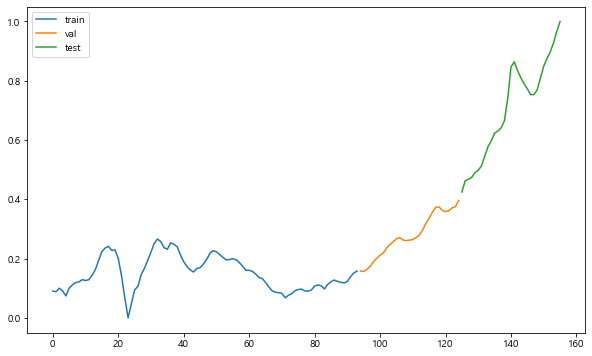

# 데이터셋 분류

In [228]:
past_history = 12
future_target = 12
STEP = 1

# X_train, y_train = multivariate_data(dataset, dataset[:, 22], 0, TRAIN_SPLIT, past_history, future_target, STEP)
# X_val, y_val = multivariate_data(dataset, dataset[:, 22], TRAIN_SPLIT, VAL_SPLIT, past_history, future_target, STEP)
X_test, y_test = multivariate_data(dataset, dataset[:, 22], VAL_SPLIT, None, past_history, future_target, STEP)

X_train, y_train = multivariate_data(dataset, dataset[:, 22], 0, VAL_SPLIT, past_history, future_target, STEP)


print('X_train : {}\n'.format(X_train.shape))
# print('X_val : {}\n'.format(X_val.shape))
print('X_test : {}'.format(X_test.shape))

BATCH_SIZE = len(X_train)
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(BATCH_SIZE).repeat()

X_train : (113, 12, 23)

X_test : (7, 12, 23)


In [229]:
train_data
val_data

<RepeatDataset shapes: ((None, 30, 23), (None, 12)), types: (tf.float64, tf.float64)>

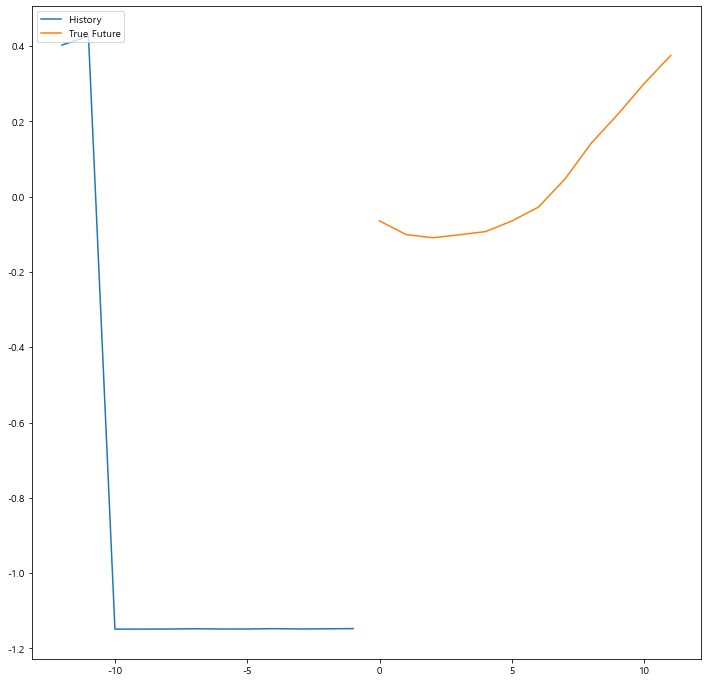

In [230]:
for x,y in train_data.take(1):
    multi_step_plot(x[0],y[0],np.array([0]))

# Sequential 모델

In [231]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, activation = 'relu', return_sequences = True, input_shape = X_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(64, activation = 'relu',return_sequences = True, input_shape = X_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(12))
model.compile(optimizer = 'sgd', loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_1647"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4579 (LSTM)             (None, 12, 128)           77824     
_________________________________________________________________
lstm_4580 (LSTM)             (None, 12, 64)            49408     
_________________________________________________________________
lstm_4581 (LSTM)             (None, 32)                12416     
_________________________________________________________________
dense_1285 (Dense)           (None, 12)                396       
Total params: 140,044
Trainable params: 140,044
Non-trainable params: 0
_________________________________________________________________


In [232]:
for x,y in val_data.take(1):
    print(model.predict(x).shape)

(1, 12)


# 모델 훈련과 평가

In [233]:
EVALUATION_INTERVAL = 10
EPOCHS = 10

history = model.fit(train_data, epochs = EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data = val_data,
                    validation_steps=50,
                    verbose = 1)

Epoch 1/10
10/10 [==============================] - 2s 188ms/step - loss: 0.3178 - accuracy: 0.0664 - val_loss: 1.0178 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 2s 150ms/step - loss: 0.3063 - accuracy: 0.0513 - val_loss: 1.0266 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 2s 153ms/step - loss: 0.2957 - accuracy: 0.0487 - val_loss: 1.0345 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 149ms/step - loss: 0.2860 - accuracy: 0.0336 - val_loss: 1.0420 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 2s 153ms/step - loss: 0.2771 - accuracy: 0.0159 - val_loss: 1.0491 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 149ms/step - loss: 0.2687 - accuracy: 0.0186 - val_loss: 1.0557 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 149ms/step - loss: 0.2606 - accuracy: 0.0265 - val_loss: 1.0624 - val

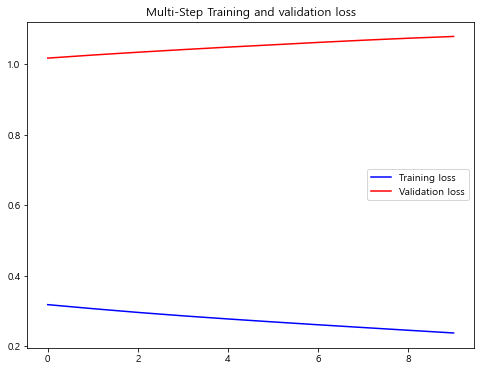

In [234]:
plot_train_history(history, 'Multi-Step Training and validation loss')

## Multi step 예측

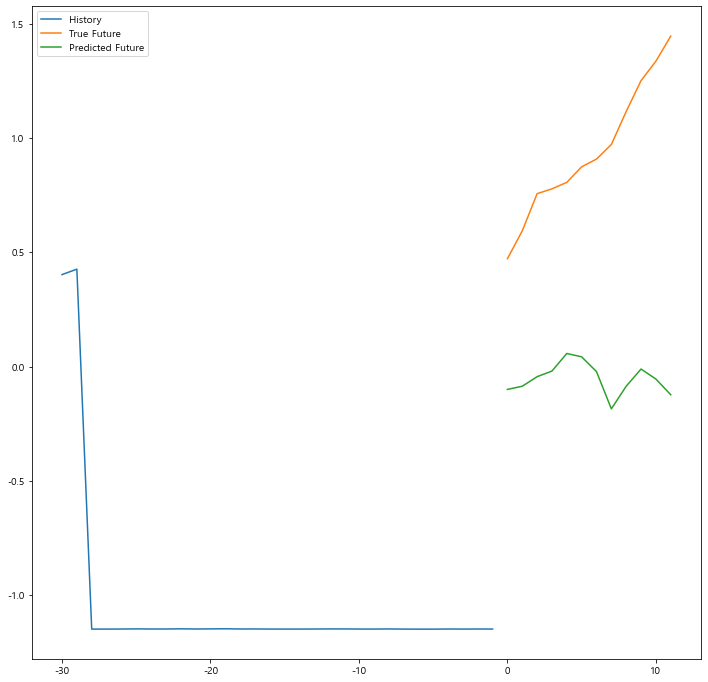

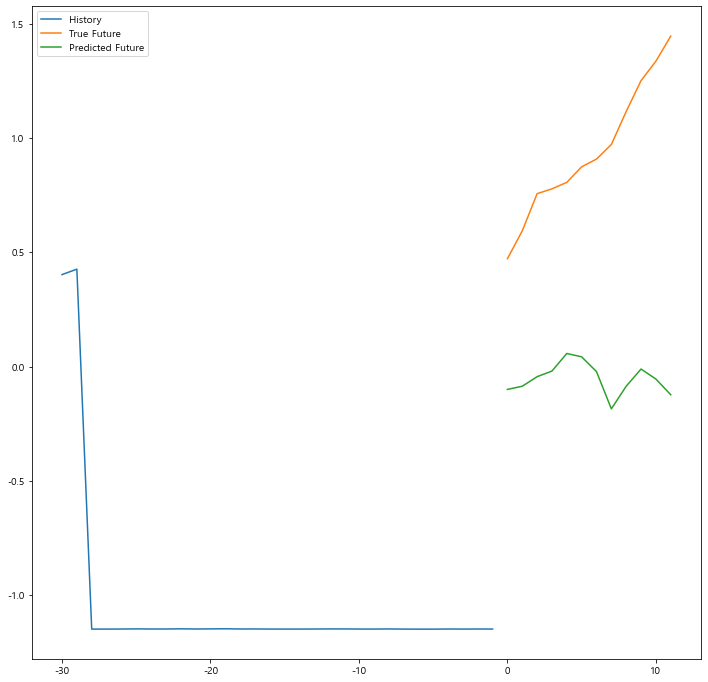

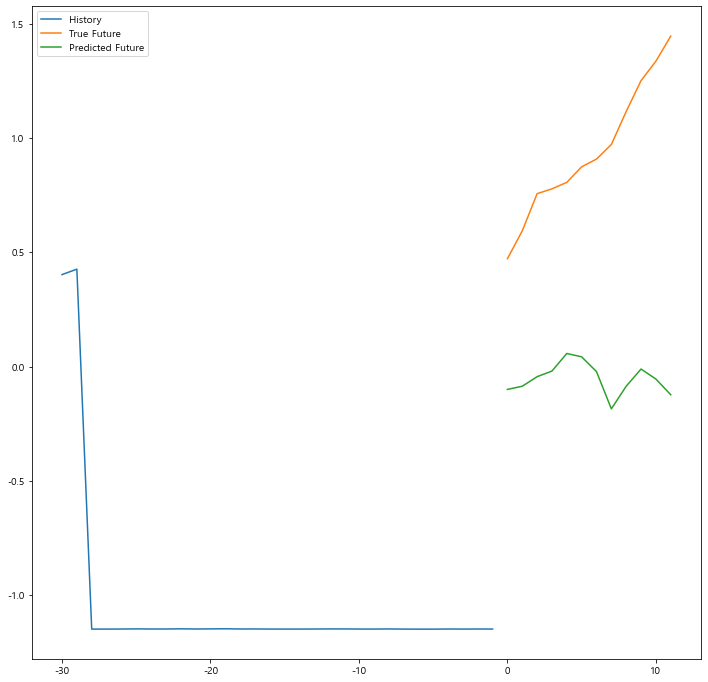

In [235]:
for x, y  in val_data.take(3):
    multi_step_plot(x[0],y[0], model.predict(x)[0])

# KerasClassifier  
# GridSearchCV

In [236]:
def classifier(optimizer, loss, activation, unit):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(unit, activation = 'relu', return_sequences = True, input_shape = X_train.shape[-2:]))
    model.add(tf.keras.layers.LSTM(unit, activation = 'relu',return_sequences = True, input_shape = X_train.shape[-2:]))
    model.add(tf.keras.layers.LSTM(unit, activation = 'relu'))
    model.add(tf.keras.layers.Dense(12))
    
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['accuracy'])
#     model.summary()
    return model

In [237]:
grid_model = KerasClassifier(classifier)

In [241]:
epochs = [500]
batches = [113]
optimizers = ['sgd', 'adam']
losses = ['mse', 'mae']
units = [64]
activationes = ['relu']

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers,
                       epochs=epochs,
                       batch_size=batches,
                       loss = losses,
                       unit = units,
                       activation = activationes
                      )

In [242]:
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = hyperparameters,
                            cv = 5)

In [243]:
grid_search = grid_search.fit(X_train, y_train)

Epoch 1/500
1/1 [==============================] - 0s 370us/step - loss: 0.3336 - accuracy: 0.1556
Epoch 2/500
1/1 [==============================] - 0s 0s/step - loss: 0.3328 - accuracy: 0.1556
Epoch 3/500
1/1 [==============================] - 0s 978us/step - loss: 0.3320 - accuracy: 0.1556
Epoch 4/500
1/1 [==============================] - 0s 997us/step - loss: 0.3312 - accuracy: 0.1556
Epoch 5/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3304 - accuracy: 0.1667
Epoch 6/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3296 - accuracy: 0.1667
Epoch 7/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3288 - accuracy: 0.1667
Epoch 8/500
1/1 [==============================] - 0s 938us/step - loss: 0.3280 - accuracy: 0.1667
Epoch 9/500
1/1 [==============================] - 0s 0s/step - loss: 0.3271 - accuracy: 0.1667
Epoch 10/500
1/1 [==============================] - 0s 865us/step - loss: 0.3263 - accuracy: 0.1667
Epoch 11/500
1/1 [===

1/1 [==============================] - 0s 999us/step - loss: 0.2666 - accuracy: 0.1778
Epoch 84/500
1/1 [==============================] - 0s 998us/step - loss: 0.2659 - accuracy: 0.1778
Epoch 85/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.1778
Epoch 86/500
1/1 [==============================] - 0s 892us/step - loss: 0.2644 - accuracy: 0.1778
Epoch 87/500
1/1 [==============================] - 0s 0s/step - loss: 0.2637 - accuracy: 0.1778
Epoch 88/500
1/1 [==============================] - 0s 0s/step - loss: 0.2630 - accuracy: 0.1778
Epoch 89/500
1/1 [==============================] - 0s 0s/step - loss: 0.2622 - accuracy: 0.1778
Epoch 90/500
1/1 [==============================] - 0s 998us/step - loss: 0.2615 - accuracy: 0.1778
Epoch 91/500
1/1 [==============================] - 0s 0s/step - loss: 0.2608 - accuracy: 0.1778
Epoch 92/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2601 - accuracy: 0.1778
Epoch 93/500
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.2120 - accuracy: 0.1889
Epoch 166/500
1/1 [==============================] - 0s 966us/step - loss: 0.2114 - accuracy: 0.1889
Epoch 167/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2107 - accuracy: 0.1778
Epoch 168/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2101 - accuracy: 0.1667
Epoch 169/500
1/1 [==============================] - 0s 0s/step - loss: 0.2095 - accuracy: 0.1778
Epoch 170/500
1/1 [==============================] - 0s 664us/step - loss: 0.2088 - accuracy: 0.1778
Epoch 171/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2082 - accuracy: 0.1778
Epoch 172/500
1/1 [==============================] - 0s 997us/step - loss: 0.2076 - accuracy: 0.1778
Epoch 173/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2069 - accuracy: 0.1778
Epoch 174/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2063 - accuracy: 0.1778
Epoch 175/500
1/1 [

1/1 [==============================] - 0s 997us/step - loss: 0.1606 - accuracy: 0.2222
Epoch 248/500
1/1 [==============================] - 0s 997us/step - loss: 0.1600 - accuracy: 0.2222
Epoch 249/500
1/1 [==============================] - 0s 374us/step - loss: 0.1594 - accuracy: 0.2333
Epoch 250/500
1/1 [==============================] - 0s 0s/step - loss: 0.1588 - accuracy: 0.2333
Epoch 251/500
1/1 [==============================] - 0s 506us/step - loss: 0.1583 - accuracy: 0.2333
Epoch 252/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1577 - accuracy: 0.2333
Epoch 253/500
1/1 [==============================] - 0s 913us/step - loss: 0.1571 - accuracy: 0.2333
Epoch 254/500
1/1 [==============================] - 0s 999us/step - loss: 0.1566 - accuracy: 0.2333
Epoch 255/500
1/1 [==============================] - 0s 961us/step - loss: 0.1560 - accuracy: 0.2333
Epoch 256/500
1/1 [==============================] - 0s 990us/step - loss: 0.1554 - accuracy: 0.2333
Epoch 257

1/1 [==============================] - 0s 1ms/step - loss: 0.1215 - accuracy: 0.2667
Epoch 330/500
1/1 [==============================] - 0s 592us/step - loss: 0.1211 - accuracy: 0.2667
Epoch 331/500
1/1 [==============================] - 0s 0s/step - loss: 0.1207 - accuracy: 0.2667
Epoch 332/500
1/1 [==============================] - 0s 0s/step - loss: 0.1204 - accuracy: 0.2667
Epoch 333/500
1/1 [==============================] - 0s 912us/step - loss: 0.1200 - accuracy: 0.2667
Epoch 334/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1196 - accuracy: 0.2667
Epoch 335/500
1/1 [==============================] - 0s 0s/step - loss: 0.1193 - accuracy: 0.2667
Epoch 336/500
1/1 [==============================] - 0s 997us/step - loss: 0.1189 - accuracy: 0.2667
Epoch 337/500
1/1 [==============================] - 0s 0s/step - loss: 0.1186 - accuracy: 0.2667
Epoch 338/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1182 - accuracy: 0.2667
Epoch 339/500
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0975 - accuracy: 0.2889
Epoch 412/500
1/1 [==============================] - 0s 0s/step - loss: 0.0973 - accuracy: 0.2889
Epoch 413/500
1/1 [==============================] - 0s 370us/step - loss: 0.0971 - accuracy: 0.2889
Epoch 414/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0969 - accuracy: 0.2889
Epoch 415/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.3111
Epoch 416/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0964 - accuracy: 0.3111
Epoch 417/500
1/1 [==============================] - 0s 996us/step - loss: 0.0962 - accuracy: 0.3111
Epoch 418/500
1/1 [==============================] - 0s 801us/step - loss: 0.0960 - accuracy: 0.3111
Epoch 419/500
1/1 [==============================] - 0s 0s/step - loss: 0.0958 - accuracy: 0.3111
Epoch 420/500
1/1 [==============================] - 0s 0s/step - loss: 0.0956 - accuracy: 0.3111
Epoch 421/500
1/

1/1 [==============================] - 0s 0s/step - loss: 0.0827 - accuracy: 0.3333
Epoch 494/500
1/1 [==============================] - 0s 0s/step - loss: 0.0825 - accuracy: 0.3333
Epoch 495/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0824 - accuracy: 0.3444
Epoch 496/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0822 - accuracy: 0.3444
Epoch 497/500
1/1 [==============================] - 0s 372us/step - loss: 0.0821 - accuracy: 0.3444
Epoch 498/500
1/1 [==============================] - 0s 0s/step - loss: 0.0820 - accuracy: 0.3444
Epoch 499/500
1/1 [==============================] - 0s 0s/step - loss: 0.0818 - accuracy: 0.3444
Epoch 500/500
1/1 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.1739
Epoch 1/500
1/1 [==============================] - 0s 997us/step - loss: 0.3527 - accuracy: 0.0778
Epoch 2/500
1/1 [==============================] - 0s 999us/step - loss: 0.3518 - accuracy: 0.0778
Epoch 3/500
1/1 [=========

1/1 [==============================] - 0s 350us/step - loss: 0.3060 - accuracy: 0.0667
Epoch 76/500
1/1 [==============================] - 0s 989us/step - loss: 0.3055 - accuracy: 0.0667
Epoch 77/500
1/1 [==============================] - 0s 0s/step - loss: 0.3050 - accuracy: 0.0667
Epoch 78/500
1/1 [==============================] - 0s 905us/step - loss: 0.3045 - accuracy: 0.0667
Epoch 79/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3040 - accuracy: 0.0667
Epoch 80/500
1/1 [==============================] - 0s 355us/step - loss: 0.3035 - accuracy: 0.0667
Epoch 81/500
1/1 [==============================] - 0s 0s/step - loss: 0.3030 - accuracy: 0.0667
Epoch 82/500
1/1 [==============================] - 0s 0s/step - loss: 0.3025 - accuracy: 0.0667
Epoch 83/500
1/1 [==============================] - 0s 434us/step - loss: 0.3020 - accuracy: 0.0667
Epoch 84/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3015 - accuracy: 0.0556
Epoch 85/500
1/1 [========

1/1 [==============================] - 0s 921us/step - loss: 0.2672 - accuracy: 0.0667
Epoch 158/500
1/1 [==============================] - 0s 999us/step - loss: 0.2668 - accuracy: 0.0667
Epoch 159/500
1/1 [==============================] - 0s 0s/step - loss: 0.2663 - accuracy: 0.0667
Epoch 160/500
1/1 [==============================] - 0s 908us/step - loss: 0.2659 - accuracy: 0.0667
Epoch 161/500
1/1 [==============================] - 0s 997us/step - loss: 0.2654 - accuracy: 0.0667
Epoch 162/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2650 - accuracy: 0.0667
Epoch 163/500
1/1 [==============================] - 0s 998us/step - loss: 0.2645 - accuracy: 0.0667
Epoch 164/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2640 - accuracy: 0.0667
Epoch 165/500
1/1 [==============================] - 0s 998us/step - loss: 0.2636 - accuracy: 0.0667
Epoch 166/500
1/1 [==============================] - 0s 998us/step - loss: 0.2631 - accuracy: 0.0667
Epoch 167/5

1/1 [==============================] - 0s 1ms/step - loss: 0.2297 - accuracy: 0.0667
Epoch 240/500
1/1 [==============================] - 0s 964us/step - loss: 0.2292 - accuracy: 0.0667
Epoch 241/500
1/1 [==============================] - 0s 0s/step - loss: 0.2287 - accuracy: 0.0667
Epoch 242/500
1/1 [==============================] - 0s 0s/step - loss: 0.2283 - accuracy: 0.0667
Epoch 243/500
1/1 [==============================] - 0s 947us/step - loss: 0.2278 - accuracy: 0.0667
Epoch 244/500
1/1 [==============================] - 0s 0s/step - loss: 0.2273 - accuracy: 0.0667
Epoch 245/500
1/1 [==============================] - 0s 0s/step - loss: 0.2268 - accuracy: 0.0667
Epoch 246/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2264 - accuracy: 0.0667
Epoch 247/500
1/1 [==============================] - 0s 973us/step - loss: 0.2259 - accuracy: 0.0667
Epoch 248/500
1/1 [==============================] - 0s 0s/step - loss: 0.2254 - accuracy: 0.0667
Epoch 249/500
1/1 [====

1/1 [==============================] - 0s 944us/step - loss: 0.1868 - accuracy: 0.0778
Epoch 322/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1863 - accuracy: 0.0778
Epoch 323/500
1/1 [==============================] - 0s 0s/step - loss: 0.1857 - accuracy: 0.0778
Epoch 324/500
1/1 [==============================] - 0s 999us/step - loss: 0.1851 - accuracy: 0.0778
Epoch 325/500
1/1 [==============================] - 0s 0s/step - loss: 0.1845 - accuracy: 0.0778
Epoch 326/500
1/1 [==============================] - 0s 889us/step - loss: 0.1840 - accuracy: 0.0778
Epoch 327/500
1/1 [==============================] - 0s 0s/step - loss: 0.1834 - accuracy: 0.0778
Epoch 328/500
1/1 [==============================] - 0s 0s/step - loss: 0.1828 - accuracy: 0.0778
Epoch 329/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1822 - accuracy: 0.0778
Epoch 330/500
1/1 [==============================] - 0s 0s/step - loss: 0.1817 - accuracy: 0.0889
Epoch 331/500
1/1 [====

1/1 [==============================] - 0s 990us/step - loss: 0.1355 - accuracy: 0.1000
Epoch 404/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.1000
Epoch 405/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1341 - accuracy: 0.1000
Epoch 406/500
1/1 [==============================] - 0s 998us/step - loss: 0.1334 - accuracy: 0.1000
Epoch 407/500
1/1 [==============================] - 0s 0s/step - loss: 0.1327 - accuracy: 0.1000
Epoch 408/500
1/1 [==============================] - 0s 343us/step - loss: 0.1320 - accuracy: 0.1000
Epoch 409/500
1/1 [==============================] - 0s 0s/step - loss: 0.1313 - accuracy: 0.1000
Epoch 410/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1306 - accuracy: 0.1000
Epoch 411/500
1/1 [==============================] - 0s 998us/step - loss: 0.1299 - accuracy: 0.1000
Epoch 412/500
1/1 [==============================] - 0s 967us/step - loss: 0.1292 - accuracy: 0.1000
Epoch 413/500
1/

1/1 [==============================] - 0s 1ms/step - loss: 0.0856 - accuracy: 0.1000
Epoch 486/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0852 - accuracy: 0.1000
Epoch 487/500
1/1 [==============================] - 0s 997us/step - loss: 0.0848 - accuracy: 0.1000
Epoch 488/500
1/1 [==============================] - 0s 0s/step - loss: 0.0844 - accuracy: 0.1000
Epoch 489/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0840 - accuracy: 0.1000
Epoch 490/500
1/1 [==============================] - 0s 396us/step - loss: 0.0836 - accuracy: 0.1000
Epoch 491/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0832 - accuracy: 0.1000
Epoch 492/500
1/1 [==============================] - 0s 0s/step - loss: 0.0828 - accuracy: 0.1000
Epoch 493/500
1/1 [==============================] - 0s 0s/step - loss: 0.0825 - accuracy: 0.1000
Epoch 494/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0821 - accuracy: 0.1000
Epoch 495/500
1/1 [====

1/1 [==============================] - 0s 357us/step - loss: 0.2133 - accuracy: 0.0667
Epoch 68/500
1/1 [==============================] - 0s 376us/step - loss: 0.2129 - accuracy: 0.0667
Epoch 69/500
1/1 [==============================] - 0s 996us/step - loss: 0.2124 - accuracy: 0.0667
Epoch 70/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2120 - accuracy: 0.0667
Epoch 71/500
1/1 [==============================] - 0s 999us/step - loss: 0.2116 - accuracy: 0.0667
Epoch 72/500
1/1 [==============================] - 0s 998us/step - loss: 0.2112 - accuracy: 0.0667
Epoch 73/500
1/1 [==============================] - 0s 0s/step - loss: 0.2107 - accuracy: 0.0667
Epoch 74/500
1/1 [==============================] - 0s 0s/step - loss: 0.2103 - accuracy: 0.0667
Epoch 75/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2099 - accuracy: 0.0667
Epoch 76/500
1/1 [==============================] - 0s 997us/step - loss: 0.2095 - accuracy: 0.0778
Epoch 77/500
1/1 [=====

1/1 [==============================] - 0s 999us/step - loss: 0.1807 - accuracy: 0.2333
Epoch 150/500
1/1 [==============================] - 0s 999us/step - loss: 0.1803 - accuracy: 0.2333
Epoch 151/500
1/1 [==============================] - 0s 0s/step - loss: 0.1800 - accuracy: 0.2333
Epoch 152/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1796 - accuracy: 0.2333
Epoch 153/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1792 - accuracy: 0.2333
Epoch 154/500
1/1 [==============================] - 0s 371us/step - loss: 0.1788 - accuracy: 0.2333
Epoch 155/500
1/1 [==============================] - 0s 0s/step - loss: 0.1784 - accuracy: 0.2333
Epoch 156/500
1/1 [==============================] - 0s 0s/step - loss: 0.1780 - accuracy: 0.2333
Epoch 157/500
1/1 [==============================] - 0s 925us/step - loss: 0.1776 - accuracy: 0.2333
Epoch 158/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1772 - accuracy: 0.2333
Epoch 159/500
1/1 [

1/1 [==============================] - 0s 0s/step - loss: 0.1495 - accuracy: 0.2333
Epoch 232/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1492 - accuracy: 0.2333
Epoch 233/500
1/1 [==============================] - 0s 998us/step - loss: 0.1489 - accuracy: 0.2333
Epoch 234/500
1/1 [==============================] - 0s 0s/step - loss: 0.1486 - accuracy: 0.2333
Epoch 235/500
1/1 [==============================] - 0s 1000us/step - loss: 0.1482 - accuracy: 0.2333
Epoch 236/500
1/1 [==============================] - 0s 0s/step - loss: 0.1479 - accuracy: 0.2333
Epoch 237/500
1/1 [==============================] - 0s 970us/step - loss: 0.1476 - accuracy: 0.2333
Epoch 238/500
1/1 [==============================] - 0s 0s/step - loss: 0.1473 - accuracy: 0.2333
Epoch 239/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1470 - accuracy: 0.2333
Epoch 240/500
1/1 [==============================] - 0s 837us/step - loss: 0.1467 - accuracy: 0.2333
Epoch 241/500
1/1 [

1/1 [==============================] - 0s 997us/step - loss: 0.1290 - accuracy: 0.2333
Epoch 314/500
1/1 [==============================] - 0s 1000us/step - loss: 0.1288 - accuracy: 0.2333
Epoch 315/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1286 - accuracy: 0.2333
Epoch 316/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1284 - accuracy: 0.2333
Epoch 317/500
1/1 [==============================] - 0s 355us/step - loss: 0.1282 - accuracy: 0.2333
Epoch 318/500
1/1 [==============================] - 0s 0s/step - loss: 0.1280 - accuracy: 0.2333
Epoch 319/500
1/1 [==============================] - 0s 0s/step - loss: 0.1278 - accuracy: 0.2333
Epoch 320/500
1/1 [==============================] - 0s 0s/step - loss: 0.1276 - accuracy: 0.2333
Epoch 321/500
1/1 [==============================] - 0s 968us/step - loss: 0.1274 - accuracy: 0.2333
Epoch 322/500
1/1 [==============================] - 0s 996us/step - loss: 0.1272 - accuracy: 0.2333
Epoch 323/500
1/

1/1 [==============================] - 0s 999us/step - loss: 0.1128 - accuracy: 0.2000
Epoch 396/500
1/1 [==============================] - 0s 340us/step - loss: 0.1127 - accuracy: 0.2000
Epoch 397/500
1/1 [==============================] - 0s 997us/step - loss: 0.1125 - accuracy: 0.2000
Epoch 398/500
1/1 [==============================] - 0s 998us/step - loss: 0.1123 - accuracy: 0.2000
Epoch 399/500
1/1 [==============================] - 0s 885us/step - loss: 0.1121 - accuracy: 0.2000
Epoch 400/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1119 - accuracy: 0.2000
Epoch 401/500
1/1 [==============================] - 0s 0s/step - loss: 0.1117 - accuracy: 0.2000
Epoch 402/500
1/1 [==============================] - 0s 364us/step - loss: 0.1115 - accuracy: 0.2000
Epoch 403/500
1/1 [==============================] - 0s 0s/step - loss: 0.1113 - accuracy: 0.2000
Epoch 404/500
1/1 [==============================] - 0s 997us/step - loss: 0.1111 - accuracy: 0.2000
Epoch 405/50

1/1 [==============================] - 0s 0s/step - loss: 0.0961 - accuracy: 0.2000
Epoch 478/500
1/1 [==============================] - 0s 0s/step - loss: 0.0959 - accuracy: 0.2000
Epoch 479/500
1/1 [==============================] - 0s 644us/step - loss: 0.0957 - accuracy: 0.2000
Epoch 480/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0955 - accuracy: 0.2000
Epoch 481/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0953 - accuracy: 0.2000
Epoch 482/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0950 - accuracy: 0.2000
Epoch 483/500
1/1 [==============================] - 0s 0s/step - loss: 0.0948 - accuracy: 0.2000
Epoch 484/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0946 - accuracy: 0.2000
Epoch 485/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0944 - accuracy: 0.2000
Epoch 486/500
1/1 [==============================] - 0s 0s/step - loss: 0.0942 - accuracy: 0.2000
Epoch 487/500
1/1 [====

1/1 [==============================] - 0s 888us/step - loss: 0.2844 - accuracy: 0.0220
Epoch 60/500
1/1 [==============================] - 0s 0s/step - loss: 0.2836 - accuracy: 0.0220
Epoch 61/500
1/1 [==============================] - 0s 343us/step - loss: 0.2828 - accuracy: 0.0220
Epoch 62/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2819 - accuracy: 0.0220
Epoch 63/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2811 - accuracy: 0.0220
Epoch 64/500
1/1 [==============================] - 0s 376us/step - loss: 0.2803 - accuracy: 0.0220
Epoch 65/500
1/1 [==============================] - 0s 378us/step - loss: 0.2794 - accuracy: 0.0220
Epoch 66/500
1/1 [==============================] - 0s 0s/step - loss: 0.2786 - accuracy: 0.0220
Epoch 67/500
1/1 [==============================] - 0s 375us/step - loss: 0.2778 - accuracy: 0.0220
Epoch 68/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2769 - accuracy: 0.0220
Epoch 69/500
1/1 [=======

1/1 [==============================] - 0s 997us/step - loss: 0.2094 - accuracy: 0.1538
Epoch 142/500
1/1 [==============================] - 0s 0s/step - loss: 0.2084 - accuracy: 0.1538
Epoch 143/500
1/1 [==============================] - 0s 997us/step - loss: 0.2074 - accuracy: 0.1538
Epoch 144/500
1/1 [==============================] - 0s 1000us/step - loss: 0.2064 - accuracy: 0.1648
Epoch 145/500
1/1 [==============================] - 0s 387us/step - loss: 0.2054 - accuracy: 0.1648
Epoch 146/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2044 - accuracy: 0.1648
Epoch 147/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2034 - accuracy: 0.1648
Epoch 148/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2024 - accuracy: 0.1648
Epoch 149/500
1/1 [==============================] - 0s 0s/step - loss: 0.2014 - accuracy: 0.1648
Epoch 150/500
1/1 [==============================] - 0s 999us/step - loss: 0.2004 - accuracy: 0.1648
Epoch 151/500
1

1/1 [==============================] - 0s 0s/step - loss: 0.1504 - accuracy: 0.2418
Epoch 224/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1499 - accuracy: 0.2418
Epoch 225/500
1/1 [==============================] - 0s 958us/step - loss: 0.1494 - accuracy: 0.2418
Epoch 226/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1490 - accuracy: 0.2418
Epoch 227/500
1/1 [==============================] - 0s 0s/step - loss: 0.1485 - accuracy: 0.2418
Epoch 228/500
1/1 [==============================] - 0s 0s/step - loss: 0.1480 - accuracy: 0.2418
Epoch 229/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1476 - accuracy: 0.2527
Epoch 230/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1471 - accuracy: 0.2527
Epoch 231/500
1/1 [==============================] - 0s 0s/step - loss: 0.1467 - accuracy: 0.2527
Epoch 232/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1462 - accuracy: 0.2527
Epoch 233/500
1/1 [=======

1/1 [==============================] - 0s 1ms/step - loss: 0.1186 - accuracy: 0.2527
Epoch 306/500
1/1 [==============================] - 0s 0s/step - loss: 0.1183 - accuracy: 0.2527
Epoch 307/500
1/1 [==============================] - 0s 0s/step - loss: 0.1180 - accuracy: 0.2527
Epoch 308/500
1/1 [==============================] - 0s 362us/step - loss: 0.1177 - accuracy: 0.2527
Epoch 309/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1174 - accuracy: 0.2527
Epoch 310/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1171 - accuracy: 0.2527
Epoch 311/500
1/1 [==============================] - 0s 952us/step - loss: 0.1169 - accuracy: 0.2527
Epoch 312/500
1/1 [==============================] - 0s 0s/step - loss: 0.1166 - accuracy: 0.2527
Epoch 313/500
1/1 [==============================] - 0s 1000us/step - loss: 0.1163 - accuracy: 0.2527
Epoch 314/500
1/1 [==============================] - 0s 917us/step - loss: 0.1160 - accuracy: 0.2527
Epoch 315/500
1/1 

1/1 [==============================] - 0s 0s/step - loss: 0.1009 - accuracy: 0.2527
Epoch 388/500
1/1 [==============================] - 0s 999us/step - loss: 0.1007 - accuracy: 0.2527
Epoch 389/500
1/1 [==============================] - 0s 0s/step - loss: 0.1006 - accuracy: 0.2527
Epoch 390/500
1/1 [==============================] - 0s 998us/step - loss: 0.1004 - accuracy: 0.2527
Epoch 391/500
1/1 [==============================] - 0s 455us/step - loss: 0.1003 - accuracy: 0.2527
Epoch 392/500
1/1 [==============================] - 0s 0s/step - loss: 0.1001 - accuracy: 0.2527
Epoch 393/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - accuracy: 0.2527
Epoch 394/500
1/1 [==============================] - 0s 0s/step - loss: 0.0998 - accuracy: 0.2527
Epoch 395/500
1/1 [==============================] - 0s 0s/step - loss: 0.0997 - accuracy: 0.2527
Epoch 396/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0996 - accuracy: 0.2527
Epoch 397/500
1/1 [=

1/1 [==============================] - 0s 0s/step - loss: 0.0914 - accuracy: 0.2637
Epoch 470/500
1/1 [==============================] - 0s 0s/step - loss: 0.0913 - accuracy: 0.2637
Epoch 471/500
1/1 [==============================] - 0s 371us/step - loss: 0.0912 - accuracy: 0.2637
Epoch 472/500
1/1 [==============================] - 0s 0s/step - loss: 0.0911 - accuracy: 0.2637
Epoch 473/500
1/1 [==============================] - 0s 0s/step - loss: 0.0910 - accuracy: 0.2637
Epoch 474/500
1/1 [==============================] - 0s 0s/step - loss: 0.0909 - accuracy: 0.2637
Epoch 475/500
1/1 [==============================] - 0s 357us/step - loss: 0.0908 - accuracy: 0.2747
Epoch 476/500
1/1 [==============================] - 0s 901us/step - loss: 0.0908 - accuracy: 0.2747
Epoch 477/500
1/1 [==============================] - 0s 338us/step - loss: 0.0907 - accuracy: 0.2747
Epoch 478/500
1/1 [==============================] - 0s 0s/step - loss: 0.0906 - accuracy: 0.2747
Epoch 479/500
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.2713 - accuracy: 0.0549
Epoch 44/500
1/1 [==============================] - 0s 999us/step - loss: 0.2699 - accuracy: 0.0549
Epoch 45/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2685 - accuracy: 0.0549
Epoch 46/500
1/1 [==============================] - 0s 0s/step - loss: 0.2671 - accuracy: 0.0549
Epoch 47/500
1/1 [==============================] - 0s 402us/step - loss: 0.2657 - accuracy: 0.0549
Epoch 48/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2643 - accuracy: 0.0549
Epoch 49/500
1/1 [==============================] - 0s 0s/step - loss: 0.2630 - accuracy: 0.0549
Epoch 50/500
1/1 [==============================] - 0s 0s/step - loss: 0.2616 - accuracy: 0.0549
Epoch 51/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2602 - accuracy: 0.0549
Epoch 52/500
1/1 [==============================] - 0s 0s/step - loss: 0.2589 - accuracy: 0.0549
Epoch 53/500
1/1 [================

1/1 [==============================] - 0s 0s/step - loss: 0.1648 - accuracy: 0.0549
Epoch 127/500
1/1 [==============================] - 0s 0s/step - loss: 0.1637 - accuracy: 0.0549
Epoch 128/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1625 - accuracy: 0.0549
Epoch 129/500
1/1 [==============================] - 0s 959us/step - loss: 0.1614 - accuracy: 0.0549
Epoch 130/500
1/1 [==============================] - 0s 0s/step - loss: 0.1602 - accuracy: 0.0549
Epoch 131/500
1/1 [==============================] - 0s 0s/step - loss: 0.1591 - accuracy: 0.0549
Epoch 132/500
1/1 [==============================] - 0s 878us/step - loss: 0.1580 - accuracy: 0.0549
Epoch 133/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1568 - accuracy: 0.0549
Epoch 134/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1557 - accuracy: 0.0549
Epoch 135/500
1/1 [==============================] - 0s 0s/step - loss: 0.1546 - accuracy: 0.0549
Epoch 136/500
1/1 [======

1/1 [==============================] - 0s 0s/step - loss: 0.0953 - accuracy: 0.0440
Epoch 209/500
1/1 [==============================] - 0s 333us/step - loss: 0.0947 - accuracy: 0.0440
Epoch 210/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0942 - accuracy: 0.0440
Epoch 211/500
1/1 [==============================] - 0s 370us/step - loss: 0.0937 - accuracy: 0.0440
Epoch 212/500
1/1 [==============================] - 0s 0s/step - loss: 0.0932 - accuracy: 0.0440
Epoch 213/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.0440
Epoch 214/500
1/1 [==============================] - 0s 0s/step - loss: 0.0922 - accuracy: 0.0440
Epoch 215/500
1/1 [==============================] - 0s 0s/step - loss: 0.0916 - accuracy: 0.0440
Epoch 216/500
1/1 [==============================] - 0s 997us/step - loss: 0.0911 - accuracy: 0.0440
Epoch 217/500
1/1 [==============================] - 0s 0s/step - loss: 0.0907 - accuracy: 0.0440
Epoch 218/500
1/1 [=

1/1 [==============================] - 0s 0s/step - loss: 0.0633 - accuracy: 0.0549
Epoch 291/500
1/1 [==============================] - 0s 968us/step - loss: 0.0631 - accuracy: 0.0549
Epoch 292/500
1/1 [==============================] - 0s 0s/step - loss: 0.0628 - accuracy: 0.0549
Epoch 293/500
1/1 [==============================] - 0s 997us/step - loss: 0.0625 - accuracy: 0.0549
Epoch 294/500
1/1 [==============================] - 0s 961us/step - loss: 0.0623 - accuracy: 0.0549
Epoch 295/500
1/1 [==============================] - 0s 0s/step - loss: 0.0620 - accuracy: 0.0549
Epoch 296/500
1/1 [==============================] - 0s 999us/step - loss: 0.0617 - accuracy: 0.0549
Epoch 297/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0615 - accuracy: 0.0549
Epoch 298/500
1/1 [==============================] - 0s 0s/step - loss: 0.0612 - accuracy: 0.0549
Epoch 299/500
1/1 [==============================] - 0s 0s/step - loss: 0.0609 - accuracy: 0.0549
Epoch 300/500
1/1 [==

1/1 [==============================] - 0s 0s/step - loss: 0.0475 - accuracy: 0.0659
Epoch 373/500
1/1 [==============================] - 0s 975us/step - loss: 0.0474 - accuracy: 0.0659
Epoch 374/500
1/1 [==============================] - 0s 342us/step - loss: 0.0473 - accuracy: 0.0659
Epoch 375/500
1/1 [==============================] - 0s 331us/step - loss: 0.0472 - accuracy: 0.0659
Epoch 376/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0470 - accuracy: 0.0659
Epoch 377/500
1/1 [==============================] - 0s 392us/step - loss: 0.0469 - accuracy: 0.0659
Epoch 378/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0468 - accuracy: 0.0659
Epoch 379/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0467 - accuracy: 0.0659
Epoch 380/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0466 - accuracy: 0.0659
Epoch 381/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0465 - accuracy: 0.0769
Epoch 382/500


1/1 [==============================] - 0s 0s/step - loss: 0.0412 - accuracy: 0.0989
Epoch 455/500
1/1 [==============================] - 0s 971us/step - loss: 0.0411 - accuracy: 0.0989
Epoch 456/500
1/1 [==============================] - 0s 999us/step - loss: 0.0411 - accuracy: 0.0989
Epoch 457/500
1/1 [==============================] - 0s 997us/step - loss: 0.0410 - accuracy: 0.0989
Epoch 458/500
1/1 [==============================] - 0s 960us/step - loss: 0.0410 - accuracy: 0.0989
Epoch 459/500
1/1 [==============================] - 0s 856us/step - loss: 0.0409 - accuracy: 0.0989
Epoch 460/500
1/1 [==============================] - 0s 374us/step - loss: 0.0409 - accuracy: 0.0989
Epoch 461/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0409 - accuracy: 0.0989
Epoch 462/500
1/1 [==============================] - 0s 377us/step - loss: 0.0408 - accuracy: 0.0989
Epoch 463/500
1/1 [==============================] - 0s 997us/step - loss: 0.0408 - accuracy: 0.0989
Epoch 464

1/1 [==============================] - 0s 1ms/step - loss: 0.0127 - accuracy: 0.3667
Epoch 29/500
1/1 [==============================] - 0s 0s/step - loss: 0.0123 - accuracy: 0.3667
Epoch 30/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0118 - accuracy: 0.3889
Epoch 31/500
1/1 [==============================] - 0s 999us/step - loss: 0.0110 - accuracy: 0.5111
Epoch 32/500
1/1 [==============================] - 0s 0s/step - loss: 0.0106 - accuracy: 0.5444
Epoch 33/500
1/1 [==============================] - 0s 998us/step - loss: 0.0107 - accuracy: 0.5444
Epoch 34/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0105 - accuracy: 0.5556
Epoch 35/500
1/1 [==============================] - 0s 485us/step - loss: 0.0101 - accuracy: 0.5778
Epoch 36/500
1/1 [==============================] - 0s 988us/step - loss: 0.0096 - accuracy: 0.5778
Epoch 37/500
1/1 [==============================] - 0s 0s/step - loss: 0.0093 - accuracy: 0.6000
Epoch 38/500
1/1 [==========

Epoch 111/500
1/1 [==============================] - 0s 0s/step - loss: 0.0034 - accuracy: 0.6111
Epoch 112/500
1/1 [==============================] - 0s 395us/step - loss: 0.0034 - accuracy: 0.6000
Epoch 113/500
1/1 [==============================] - 0s 997us/step - loss: 0.0033 - accuracy: 0.6000
Epoch 114/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.6000
Epoch 115/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.6000
Epoch 116/500
1/1 [==============================] - 0s 0s/step - loss: 0.0033 - accuracy: 0.6000
Epoch 117/500
1/1 [==============================] - 0s 0s/step - loss: 0.0033 - accuracy: 0.6000
Epoch 118/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.6111
Epoch 119/500
1/1 [==============================] - 0s 0s/step - loss: 0.0032 - accuracy: 0.6111
Epoch 120/500
1/1 [==============================] - 0s 0s/step - loss: 0.0032 - accuracy: 0.6111
Epoch 121/5

1/1 [==============================] - 0s 999us/step - loss: 0.0015 - accuracy: 0.6222
Epoch 194/500
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.6222
Epoch 195/500
1/1 [==============================] - 0s 999us/step - loss: 0.0014 - accuracy: 0.6222
Epoch 196/500
1/1 [==============================] - 0s 999us/step - loss: 0.0014 - accuracy: 0.6222
Epoch 197/500
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - accuracy: 0.6222
Epoch 198/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0014 - accuracy: 0.6222
Epoch 199/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.6222
Epoch 200/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.6222
Epoch 201/500
1/1 [==============================] - 0s 970us/step - loss: 0.0013 - accuracy: 0.6222
Epoch 202/500
1/1 [==============================] - 0s 998us/step - loss: 0.0013 - accuracy: 0.6222
Epoch 203/500

1/1 [==============================] - 0s 925us/step - loss: 6.4155e-04 - accuracy: 0.6778
Epoch 274/500
1/1 [==============================] - 0s 999us/step - loss: 6.3805e-04 - accuracy: 0.6667
Epoch 275/500
1/1 [==============================] - 0s 997us/step - loss: 6.4317e-04 - accuracy: 0.6667
Epoch 276/500
1/1 [==============================] - 0s 365us/step - loss: 6.2810e-04 - accuracy: 0.6778
Epoch 277/500
1/1 [==============================] - 0s 1ms/step - loss: 6.2495e-04 - accuracy: 0.6667
Epoch 278/500
1/1 [==============================] - 0s 1ms/step - loss: 6.1345e-04 - accuracy: 0.6889
Epoch 279/500
1/1 [==============================] - 0s 0s/step - loss: 6.1160e-04 - accuracy: 0.6778
Epoch 280/500
1/1 [==============================] - 0s 1ms/step - loss: 6.0788e-04 - accuracy: 0.6889
Epoch 281/500
1/1 [==============================] - 0s 0s/step - loss: 5.9739e-04 - accuracy: 0.6778
Epoch 282/500
1/1 [==============================] - 0s 419us/step - loss: 6.0160

1/1 [==============================] - 0s 998us/step - loss: 4.3649e-04 - accuracy: 0.7444
Epoch 353/500
1/1 [==============================] - 0s 1ms/step - loss: 4.3512e-04 - accuracy: 0.7333
Epoch 354/500
1/1 [==============================] - 0s 997us/step - loss: 4.4126e-04 - accuracy: 0.7778
Epoch 355/500
1/1 [==============================] - 0s 0s/step - loss: 4.4585e-04 - accuracy: 0.7333
Epoch 356/500
1/1 [==============================] - 0s 415us/step - loss: 4.4566e-04 - accuracy: 0.7778
Epoch 357/500
1/1 [==============================] - 0s 997us/step - loss: 4.3964e-04 - accuracy: 0.7333
Epoch 358/500
1/1 [==============================] - 0s 391us/step - loss: 4.3892e-04 - accuracy: 0.7444
Epoch 359/500
1/1 [==============================] - 0s 997us/step - loss: 4.4220e-04 - accuracy: 0.7556
Epoch 360/500
1/1 [==============================] - 0s 999us/step - loss: 4.5600e-04 - accuracy: 0.7333
Epoch 361/500
1/1 [==============================] - 0s 958us/step - loss:

1/1 [==============================] - 0s 999us/step - loss: 3.8195e-04 - accuracy: 0.7778
Epoch 432/500
1/1 [==============================] - 0s 999us/step - loss: 3.8467e-04 - accuracy: 0.7778
Epoch 433/500
1/1 [==============================] - 0s 998us/step - loss: 3.9846e-04 - accuracy: 0.8000
Epoch 434/500
1/1 [==============================] - 0s 949us/step - loss: 4.0995e-04 - accuracy: 0.7667
Epoch 435/500
1/1 [==============================] - 0s 949us/step - loss: 4.1441e-04 - accuracy: 0.7889
Epoch 436/500
1/1 [==============================] - 0s 1ms/step - loss: 3.8464e-04 - accuracy: 0.7778
Epoch 437/500
1/1 [==============================] - 0s 969us/step - loss: 3.6355e-04 - accuracy: 0.7667
Epoch 438/500
1/1 [==============================] - 0s 0s/step - loss: 3.5558e-04 - accuracy: 0.7889
Epoch 439/500
1/1 [==============================] - 0s 926us/step - loss: 3.5548e-04 - accuracy: 0.8000
Epoch 440/500
1/1 [==============================] - 0s 783us/step - loss:

1/1 [==============================] - 0s 341us/step - loss: 0.3437 - accuracy: 0.0778
Epoch 3/500
1/1 [==============================] - 0s 0s/step - loss: 0.3340 - accuracy: 0.0778
Epoch 4/500
1/1 [==============================] - 0s 0s/step - loss: 0.3235 - accuracy: 0.0667
Epoch 5/500
1/1 [==============================] - 0s 0s/step - loss: 0.3113 - accuracy: 0.0667
Epoch 6/500
1/1 [==============================] - 0s 354us/step - loss: 0.2967 - accuracy: 0.0667
Epoch 7/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2793 - accuracy: 0.0667
Epoch 8/500
1/1 [==============================] - 0s 0s/step - loss: 0.2601 - accuracy: 0.0667
Epoch 9/500
1/1 [==============================] - 0s 0s/step - loss: 0.2475 - accuracy: 0.0667
Epoch 10/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2362 - accuracy: 0.0667
Epoch 11/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2162 - accuracy: 0.0778
Epoch 12/500
1/1 [=======================

1/1 [==============================] - 0s 0s/step - loss: 0.0042 - accuracy: 0.5333
Epoch 86/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.5222
Epoch 87/500
1/1 [==============================] - 0s 824us/step - loss: 0.0041 - accuracy: 0.5222
Epoch 88/500
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.5222
Epoch 89/500
1/1 [==============================] - 0s 895us/step - loss: 0.0040 - accuracy: 0.5444
Epoch 90/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.5222
Epoch 91/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 0.5222
Epoch 92/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 0.5333
Epoch 93/500
1/1 [==============================] - 0s 405us/step - loss: 0.0037 - accuracy: 0.5444
Epoch 94/500
1/1 [==============================] - 0s 952us/step - loss: 0.0037 - accuracy: 0.5333
Epoch 95/500
1/1 [=========

1/1 [==============================] - 0s 990us/step - loss: 0.0020 - accuracy: 0.6556
Epoch 168/500
1/1 [==============================] - 0s 396us/step - loss: 0.0020 - accuracy: 0.6444
Epoch 169/500
1/1 [==============================] - 0s 985us/step - loss: 0.0020 - accuracy: 0.6333
Epoch 170/500
1/1 [==============================] - 0s 999us/step - loss: 0.0020 - accuracy: 0.6444
Epoch 171/500
1/1 [==============================] - 0s 668us/step - loss: 0.0019 - accuracy: 0.6889
Epoch 172/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 0.6667
Epoch 173/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.6667
Epoch 174/500
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - accuracy: 0.6556
Epoch 175/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.6444
Epoch 176/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.6778
Epoch 177/500
1

1/1 [==============================] - 0s 1000us/step - loss: 9.4137e-04 - accuracy: 0.7667
Epoch 250/500
1/1 [==============================] - 0s 0s/step - loss: 9.1487e-04 - accuracy: 0.7556
Epoch 251/500
1/1 [==============================] - 0s 0s/step - loss: 9.5152e-04 - accuracy: 0.7667
Epoch 252/500
1/1 [==============================] - 0s 999us/step - loss: 8.9847e-04 - accuracy: 0.7556
Epoch 253/500
1/1 [==============================] - 0s 1ms/step - loss: 9.0505e-04 - accuracy: 0.7667
Epoch 254/500
1/1 [==============================] - 0s 775us/step - loss: 9.0695e-04 - accuracy: 0.7556
Epoch 255/500
1/1 [==============================] - 0s 998us/step - loss: 8.8146e-04 - accuracy: 0.7667
Epoch 256/500
1/1 [==============================] - 0s 0s/step - loss: 8.7079e-04 - accuracy: 0.7556
Epoch 257/500
1/1 [==============================] - 0s 0s/step - loss: 8.7998e-04 - accuracy: 0.7889
Epoch 258/500
1/1 [==============================] - 0s 1ms/step - loss: 8.5907e-0

1/1 [==============================] - 0s 339us/step - loss: 6.1470e-04 - accuracy: 0.8222
Epoch 329/500
1/1 [==============================] - 0s 1ms/step - loss: 6.1674e-04 - accuracy: 0.7889
Epoch 330/500
1/1 [==============================] - 0s 1ms/step - loss: 6.1036e-04 - accuracy: 0.8111
Epoch 331/500
1/1 [==============================] - 0s 711us/step - loss: 5.8663e-04 - accuracy: 0.8000
Epoch 332/500
1/1 [==============================] - 0s 1ms/step - loss: 5.6904e-04 - accuracy: 0.8222
Epoch 333/500
1/1 [==============================] - 0s 0s/step - loss: 5.6697e-04 - accuracy: 0.8000
Epoch 334/500
1/1 [==============================] - 0s 0s/step - loss: 5.7584e-04 - accuracy: 0.8222
Epoch 335/500
1/1 [==============================] - 0s 997us/step - loss: 5.8192e-04 - accuracy: 0.8000
Epoch 336/500
1/1 [==============================] - 0s 359us/step - loss: 5.7120e-04 - accuracy: 0.8000
Epoch 337/500
1/1 [==============================] - 0s 0s/step - loss: 5.5970e-0

1/1 [==============================] - 0s 1ms/step - loss: 4.9968e-04 - accuracy: 0.8333
Epoch 408/500
1/1 [==============================] - 0s 0s/step - loss: 5.1647e-04 - accuracy: 0.8000
Epoch 409/500
1/1 [==============================] - 0s 998us/step - loss: 5.0655e-04 - accuracy: 0.8333
Epoch 410/500
1/1 [==============================] - 0s 1ms/step - loss: 4.9892e-04 - accuracy: 0.8111
Epoch 411/500
1/1 [==============================] - 0s 365us/step - loss: 4.9908e-04 - accuracy: 0.8333
Epoch 412/500
1/1 [==============================] - 0s 389us/step - loss: 5.1285e-04 - accuracy: 0.8111
Epoch 413/500
1/1 [==============================] - 0s 0s/step - loss: 5.3769e-04 - accuracy: 0.8222
Epoch 414/500
1/1 [==============================] - 0s 1ms/step - loss: 5.4351e-04 - accuracy: 0.8222
Epoch 415/500
1/1 [==============================] - 0s 0s/step - loss: 5.6109e-04 - accuracy: 0.8111
Epoch 416/500
1/1 [==============================] - 0s 999us/step - loss: 5.3977e-0

1/1 [==============================] - 0s 0s/step - loss: 5.1127e-04 - accuracy: 0.8333
Epoch 487/500
1/1 [==============================] - 0s 998us/step - loss: 5.6236e-04 - accuracy: 0.8667
Epoch 488/500
1/1 [==============================] - 0s 0s/step - loss: 5.9300e-04 - accuracy: 0.8333
Epoch 489/500
1/1 [==============================] - 0s 0s/step - loss: 6.3448e-04 - accuracy: 0.8556
Epoch 490/500
1/1 [==============================] - 0s 2ms/step - loss: 5.7737e-04 - accuracy: 0.8222
Epoch 491/500
1/1 [==============================] - 0s 999us/step - loss: 5.0986e-04 - accuracy: 0.8667
Epoch 492/500
1/1 [==============================] - 0s 0s/step - loss: 4.2276e-04 - accuracy: 0.8444
Epoch 493/500
1/1 [==============================] - 0s 1ms/step - loss: 3.8918e-04 - accuracy: 0.8444
Epoch 494/500
1/1 [==============================] - 0s 0s/step - loss: 4.1614e-04 - accuracy: 0.8556
Epoch 495/500
1/1 [==============================] - 0s 0s/step - loss: 4.5226e-04 - acc

1/1 [==============================] - 0s 890us/step - loss: 0.0076 - accuracy: 0.4333
Epoch 61/500
1/1 [==============================] - 0s 0s/step - loss: 0.0074 - accuracy: 0.4333
Epoch 62/500
1/1 [==============================] - 0s 0s/step - loss: 0.0071 - accuracy: 0.4667
Epoch 63/500
1/1 [==============================] - 0s 370us/step - loss: 0.0069 - accuracy: 0.4778
Epoch 64/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 0.4778
Epoch 65/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.4889
Epoch 66/500
1/1 [==============================] - 0s 999us/step - loss: 0.0064 - accuracy: 0.5000
Epoch 67/500
1/1 [==============================] - 0s 0s/step - loss: 0.0062 - accuracy: 0.5222
Epoch 68/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.5222
Epoch 69/500
1/1 [==============================] - 0s 303us/step - loss: 0.0060 - accuracy: 0.5222
Epoch 70/500
1/1 [==========

1/1 [==============================] - 0s 999us/step - loss: 0.0017 - accuracy: 0.5667
Epoch 143/500
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - accuracy: 0.5667
Epoch 144/500
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - accuracy: 0.5778
Epoch 145/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.5556
Epoch 146/500
1/1 [==============================] - 0s 999us/step - loss: 0.0017 - accuracy: 0.5778
Epoch 147/500
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.5667
Epoch 148/500
1/1 [==============================] - 0s 999us/step - loss: 0.0016 - accuracy: 0.5667
Epoch 149/500
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.5667
Epoch 150/500
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.5667
Epoch 151/500
1/1 [==============================] - 0s 909us/step - loss: 0.0015 - accuracy: 0.5667
Epoch 152/500
1/1 [==

1/1 [==============================] - 0s 254us/step - loss: 7.7056e-04 - accuracy: 0.7111
Epoch 224/500
1/1 [==============================] - 0s 999us/step - loss: 8.1082e-04 - accuracy: 0.7111
Epoch 225/500
1/1 [==============================] - 0s 965us/step - loss: 7.8157e-04 - accuracy: 0.7333
Epoch 226/500
1/1 [==============================] - 0s 0s/step - loss: 7.5317e-04 - accuracy: 0.7111
Epoch 227/500
1/1 [==============================] - 0s 0s/step - loss: 7.8238e-04 - accuracy: 0.7111
Epoch 228/500
1/1 [==============================] - 0s 1ms/step - loss: 7.5669e-04 - accuracy: 0.7444
Epoch 229/500
1/1 [==============================] - 0s 999us/step - loss: 7.4073e-04 - accuracy: 0.7222
Epoch 230/500
1/1 [==============================] - 0s 1ms/step - loss: 7.5914e-04 - accuracy: 0.7444
Epoch 231/500
1/1 [==============================] - 0s 270us/step - loss: 7.4322e-04 - accuracy: 0.7444
Epoch 232/500
1/1 [==============================] - 0s 356us/step - loss: 7.43

1/1 [==============================] - 0s 0s/step - loss: 5.5394e-04 - accuracy: 0.7889
Epoch 303/500
1/1 [==============================] - 0s 1ms/step - loss: 6.1510e-04 - accuracy: 0.8111
Epoch 304/500
1/1 [==============================] - 0s 998us/step - loss: 6.9834e-04 - accuracy: 0.7667
Epoch 305/500
1/1 [==============================] - 0s 0s/step - loss: 7.4721e-04 - accuracy: 0.7556
Epoch 306/500
1/1 [==============================] - 0s 998us/step - loss: 6.9787e-04 - accuracy: 0.7667
Epoch 307/500
1/1 [==============================] - 0s 595us/step - loss: 5.7087e-04 - accuracy: 0.7889
Epoch 308/500
1/1 [==============================] - 0s 998us/step - loss: 5.2056e-04 - accuracy: 0.8444
Epoch 309/500
1/1 [==============================] - 0s 901us/step - loss: 5.7442e-04 - accuracy: 0.8222
Epoch 310/500
1/1 [==============================] - 0s 1ms/step - loss: 5.7645e-04 - accuracy: 0.8111
Epoch 311/500
1/1 [==============================] - 0s 1ms/step - loss: 5.1550

1/1 [==============================] - 0s 971us/step - loss: 3.8367e-04 - accuracy: 0.8222
Epoch 382/500
1/1 [==============================] - 0s 1ms/step - loss: 3.8001e-04 - accuracy: 0.8222
Epoch 383/500
1/1 [==============================] - 0s 997us/step - loss: 3.7833e-04 - accuracy: 0.8222
Epoch 384/500
1/1 [==============================] - 0s 1ms/step - loss: 3.7723e-04 - accuracy: 0.8222
Epoch 385/500
1/1 [==============================] - 0s 472us/step - loss: 3.7578e-04 - accuracy: 0.8222
Epoch 386/500
1/1 [==============================] - 0s 0s/step - loss: 3.7334e-04 - accuracy: 0.8222
Epoch 387/500
1/1 [==============================] - 0s 377us/step - loss: 3.7177e-04 - accuracy: 0.8222
Epoch 388/500
1/1 [==============================] - 0s 401us/step - loss: 3.7126e-04 - accuracy: 0.8222
Epoch 389/500
1/1 [==============================] - 0s 1ms/step - loss: 3.7108e-04 - accuracy: 0.8222
Epoch 390/500
1/1 [==============================] - 0s 597us/step - loss: 3.7

1/1 [==============================] - 0s 1ms/step - loss: 3.0518e-04 - accuracy: 0.8556
Epoch 461/500
1/1 [==============================] - 0s 0s/step - loss: 3.3929e-04 - accuracy: 0.8444
Epoch 462/500
1/1 [==============================] - 0s 360us/step - loss: 3.8407e-04 - accuracy: 0.8333
Epoch 463/500
1/1 [==============================] - 0s 999us/step - loss: 3.7199e-04 - accuracy: 0.8444
Epoch 464/500
1/1 [==============================] - 0s 997us/step - loss: 3.3827e-04 - accuracy: 0.8556
Epoch 465/500
1/1 [==============================] - 0s 0s/step - loss: 3.0540e-04 - accuracy: 0.8556
Epoch 466/500
1/1 [==============================] - 0s 0s/step - loss: 3.1093e-04 - accuracy: 0.8556
Epoch 467/500
1/1 [==============================] - 0s 920us/step - loss: 3.3899e-04 - accuracy: 0.8667
Epoch 468/500
1/1 [==============================] - 0s 1ms/step - loss: 3.4770e-04 - accuracy: 0.8556
Epoch 469/500
1/1 [==============================] - 0s 0s/step - loss: 3.3671e-04

1/1 [==============================] - 0s 0s/step - loss: 0.0351 - accuracy: 0.4176
Epoch 33/500
1/1 [==============================] - 0s 998us/step - loss: 0.0321 - accuracy: 0.4066
Epoch 34/500
1/1 [==============================] - 0s 628us/step - loss: 0.0301 - accuracy: 0.3626
Epoch 35/500
1/1 [==============================] - 0s 354us/step - loss: 0.0288 - accuracy: 0.3956
Epoch 36/500
1/1 [==============================] - 0s 0s/step - loss: 0.0279 - accuracy: 0.3736
Epoch 37/500
1/1 [==============================] - 0s 350us/step - loss: 0.0271 - accuracy: 0.3516
Epoch 38/500
1/1 [==============================] - 0s 0s/step - loss: 0.0259 - accuracy: 0.3626
Epoch 39/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0244 - accuracy: 0.3407
Epoch 40/500
1/1 [==============================] - 0s 0s/step - loss: 0.0231 - accuracy: 0.3516
Epoch 41/500
1/1 [==============================] - 0s 0s/step - loss: 0.0220 - accuracy: 0.3736
Epoch 42/500
1/1 [============

1/1 [==============================] - 0s 0s/step - loss: 0.0033 - accuracy: 0.5385
Epoch 116/500
1/1 [==============================] - 0s 883us/step - loss: 0.0032 - accuracy: 0.5385
Epoch 117/500
1/1 [==============================] - 0s 925us/step - loss: 0.0032 - accuracy: 0.5385
Epoch 118/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 0.5275
Epoch 119/500
1/1 [==============================] - 0s 866us/step - loss: 0.0031 - accuracy: 0.5055
Epoch 120/500
1/1 [==============================] - 0s 999us/step - loss: 0.0030 - accuracy: 0.5275
Epoch 121/500
1/1 [==============================] - 0s 722us/step - loss: 0.0030 - accuracy: 0.5275
Epoch 122/500
1/1 [==============================] - 0s 999us/step - loss: 0.0029 - accuracy: 0.5165
Epoch 123/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.5165
Epoch 124/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 0.5165
Epoch 125/500

1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.6593
Epoch 198/500
1/1 [==============================] - 0s 861us/step - loss: 0.0012 - accuracy: 0.6374
Epoch 199/500
1/1 [==============================] - 0s 364us/step - loss: 0.0012 - accuracy: 0.6154
Epoch 200/500
1/1 [==============================] - 0s 288us/step - loss: 0.0012 - accuracy: 0.6593
Epoch 201/500
1/1 [==============================] - 0s 998us/step - loss: 0.0012 - accuracy: 0.6374
Epoch 202/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 0.6154
Epoch 203/500
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - accuracy: 0.6154
Epoch 204/500
1/1 [==============================] - 0s 965us/step - loss: 0.0011 - accuracy: 0.6593
Epoch 205/500
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - accuracy: 0.6703
Epoch 206/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 0.6484
Epoch 207/500
1/

1/1 [==============================] - 0s 1ms/step - loss: 6.6834e-04 - accuracy: 0.7363
Epoch 277/500
1/1 [==============================] - 0s 0s/step - loss: 6.1831e-04 - accuracy: 0.7363
Epoch 278/500
1/1 [==============================] - 0s 681us/step - loss: 6.2016e-04 - accuracy: 0.7473
Epoch 279/500
1/1 [==============================] - 0s 969us/step - loss: 6.5566e-04 - accuracy: 0.7473
Epoch 280/500
1/1 [==============================] - 0s 1ms/step - loss: 6.2471e-04 - accuracy: 0.7363
Epoch 281/500
1/1 [==============================] - 0s 0s/step - loss: 5.9882e-04 - accuracy: 0.7363
Epoch 282/500
1/1 [==============================] - 0s 0s/step - loss: 6.1905e-04 - accuracy: 0.7363
Epoch 283/500
1/1 [==============================] - 0s 998us/step - loss: 6.2052e-04 - accuracy: 0.7912
Epoch 284/500
1/1 [==============================] - 0s 0s/step - loss: 5.9037e-04 - accuracy: 0.7473
Epoch 285/500
1/1 [==============================] - 0s 0s/step - loss: 5.8418e-04 - 

1/1 [==============================] - 0s 1ms/step - loss: 4.6634e-04 - accuracy: 0.7802
Epoch 356/500
1/1 [==============================] - 0s 0s/step - loss: 4.5647e-04 - accuracy: 0.7692
Epoch 357/500
1/1 [==============================] - 0s 998us/step - loss: 4.5408e-04 - accuracy: 0.7692
Epoch 358/500
1/1 [==============================] - 0s 0s/step - loss: 4.5792e-04 - accuracy: 0.7692
Epoch 359/500
1/1 [==============================] - 0s 940us/step - loss: 4.6120e-04 - accuracy: 0.7802
Epoch 360/500
1/1 [==============================] - 0s 1ms/step - loss: 4.5977e-04 - accuracy: 0.7802
Epoch 361/500
1/1 [==============================] - 0s 1ms/step - loss: 4.5609e-04 - accuracy: 0.7802
Epoch 362/500
1/1 [==============================] - 0s 0s/step - loss: 4.5333e-04 - accuracy: 0.7692
Epoch 363/500
1/1 [==============================] - 0s 0s/step - loss: 4.5591e-04 - accuracy: 0.7802
Epoch 364/500
1/1 [==============================] - 0s 1ms/step - loss: 4.6383e-04 - a

1/1 [==============================] - 0s 878us/step - loss: 4.1111e-04 - accuracy: 0.7802
Epoch 435/500
1/1 [==============================] - 0s 1ms/step - loss: 4.2805e-04 - accuracy: 0.7802
Epoch 436/500
1/1 [==============================] - 0s 1ms/step - loss: 4.2665e-04 - accuracy: 0.7912
Epoch 437/500
1/1 [==============================] - 0s 1000us/step - loss: 4.2413e-04 - accuracy: 0.7692
Epoch 438/500
1/1 [==============================] - 0s 0s/step - loss: 4.3291e-04 - accuracy: 0.7802
Epoch 439/500
1/1 [==============================] - 0s 997us/step - loss: 4.5965e-04 - accuracy: 0.7912
Epoch 440/500
1/1 [==============================] - 0s 1ms/step - loss: 4.7543e-04 - accuracy: 0.7802
Epoch 441/500
1/1 [==============================] - 0s 351us/step - loss: 4.7786e-04 - accuracy: 0.7912
Epoch 442/500
1/1 [==============================] - 0s 0s/step - loss: 4.6194e-04 - accuracy: 0.7912
Epoch 443/500
1/1 [==============================] - 0s 936us/step - loss: 4.511

1/1 [==============================] - 0s 999us/step - loss: 0.2719 - accuracy: 0.0659
Epoch 6/500
1/1 [==============================] - 0s 0s/step - loss: 0.2533 - accuracy: 0.0659
Epoch 7/500
1/1 [==============================] - 0s 999us/step - loss: 0.2391 - accuracy: 0.0659
Epoch 8/500
1/1 [==============================] - 0s 0s/step - loss: 0.2179 - accuracy: 0.0659
Epoch 9/500
1/1 [==============================] - 0s 0s/step - loss: 0.1930 - accuracy: 0.0659
Epoch 10/500
1/1 [==============================] - 0s 999us/step - loss: 0.1684 - accuracy: 0.0659
Epoch 11/500
1/1 [==============================] - 0s 830us/step - loss: 0.1437 - accuracy: 0.0659
Epoch 12/500
1/1 [==============================] - 0s 0s/step - loss: 0.1200 - accuracy: 0.0659
Epoch 13/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1023 - accuracy: 0.0440
Epoch 14/500
1/1 [==============================] - 0s 999us/step - loss: 0.0961 - accuracy: 0.0549
Epoch 15/500
1/1 [=============

1/1 [==============================] - 0s 0s/step - loss: 0.0041 - accuracy: 0.4176
Epoch 89/500
1/1 [==============================] - 0s 998us/step - loss: 0.0041 - accuracy: 0.3626
Epoch 90/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.3956
Epoch 91/500
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.3626
Epoch 92/500
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - accuracy: 0.3846
Epoch 93/500
1/1 [==============================] - 0s 999us/step - loss: 0.0037 - accuracy: 0.4066
Epoch 94/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.3956
Epoch 95/500
1/1 [==============================] - 0s 997us/step - loss: 0.0037 - accuracy: 0.4176
Epoch 96/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.4396
Epoch 97/500
1/1 [==============================] - 0s 0s/step - loss: 0.0035 - accuracy: 0.4615
Epoch 98/500
1/1 [=============

1/1 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.5385
Epoch 171/500
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - accuracy: 0.5165
Epoch 172/500
1/1 [==============================] - 0s 387us/step - loss: 0.0012 - accuracy: 0.5385
Epoch 173/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.5165
Epoch 174/500
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - accuracy: 0.5165
Epoch 175/500
1/1 [==============================] - 0s 999us/step - loss: 0.0012 - accuracy: 0.5165
Epoch 176/500
1/1 [==============================] - 0s 955us/step - loss: 0.0012 - accuracy: 0.5165
Epoch 177/500
1/1 [==============================] - 0s 998us/step - loss: 0.0012 - accuracy: 0.5165
Epoch 178/500
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - accuracy: 0.5165
Epoch 179/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.5385
Epoch 180/500
1/1 [

1/1 [==============================] - 0s 644us/step - loss: 8.4768e-04 - accuracy: 0.5714
Epoch 252/500
1/1 [==============================] - 0s 0s/step - loss: 8.3621e-04 - accuracy: 0.5604
Epoch 253/500
1/1 [==============================] - 0s 1000us/step - loss: 8.2576e-04 - accuracy: 0.5824
Epoch 254/500
1/1 [==============================] - 0s 998us/step - loss: 8.3277e-04 - accuracy: 0.5824
Epoch 255/500
1/1 [==============================] - 0s 1ms/step - loss: 8.1747e-04 - accuracy: 0.5714
Epoch 256/500
1/1 [==============================] - 0s 999us/step - loss: 8.1764e-04 - accuracy: 0.5714
Epoch 257/500
1/1 [==============================] - 0s 894us/step - loss: 8.2551e-04 - accuracy: 0.5714
Epoch 258/500
1/1 [==============================] - 0s 1ms/step - loss: 8.0674e-04 - accuracy: 0.5714
Epoch 259/500
1/1 [==============================] - 0s 1ms/step - loss: 8.0472e-04 - accuracy: 0.5714
Epoch 260/500
1/1 [==============================] - 0s 357us/step - loss: 8.

1/1 [==============================] - 0s 997us/step - loss: 6.5323e-04 - accuracy: 0.6264
Epoch 331/500
1/1 [==============================] - 0s 1ms/step - loss: 6.5341e-04 - accuracy: 0.6374
Epoch 332/500
1/1 [==============================] - 0s 365us/step - loss: 6.4921e-04 - accuracy: 0.6374
Epoch 333/500
1/1 [==============================] - 0s 1ms/step - loss: 6.4509e-04 - accuracy: 0.6484
Epoch 334/500
1/1 [==============================] - 0s 0s/step - loss: 6.3835e-04 - accuracy: 0.6484
Epoch 335/500
1/1 [==============================] - 0s 996us/step - loss: 6.3238e-04 - accuracy: 0.6484
Epoch 336/500
1/1 [==============================] - 0s 933us/step - loss: 6.2726e-04 - accuracy: 0.6593
Epoch 337/500
1/1 [==============================] - 0s 0s/step - loss: 6.2323e-04 - accuracy: 0.6593
Epoch 338/500
1/1 [==============================] - 0s 997us/step - loss: 6.1981e-04 - accuracy: 0.6593
Epoch 339/500
1/1 [==============================] - 0s 401us/step - loss: 6.17

1/1 [==============================] - 0s 2ms/step - loss: 5.1533e-04 - accuracy: 0.6703
Epoch 410/500
1/1 [==============================] - 0s 998us/step - loss: 5.1909e-04 - accuracy: 0.7033
Epoch 411/500
1/1 [==============================] - 0s 888us/step - loss: 5.2484e-04 - accuracy: 0.6703
Epoch 412/500
1/1 [==============================] - 0s 0s/step - loss: 5.3360e-04 - accuracy: 0.7143
Epoch 413/500
1/1 [==============================] - 0s 867us/step - loss: 5.4789e-04 - accuracy: 0.6593
Epoch 414/500
1/1 [==============================] - 0s 0s/step - loss: 5.5802e-04 - accuracy: 0.7143
Epoch 415/500
1/1 [==============================] - 0s 351us/step - loss: 5.7614e-04 - accuracy: 0.6593
Epoch 416/500
1/1 [==============================] - 0s 1ms/step - loss: 5.7529e-04 - accuracy: 0.7033
Epoch 417/500
1/1 [==============================] - 0s 0s/step - loss: 5.8320e-04 - accuracy: 0.6484
Epoch 418/500
1/1 [==============================] - 0s 959us/step - loss: 5.6240e

1/1 [==============================] - 0s 942us/step - loss: 4.1222e-04 - accuracy: 0.6923
Epoch 489/500
1/1 [==============================] - 0s 981us/step - loss: 4.1947e-04 - accuracy: 0.7143
Epoch 490/500
1/1 [==============================] - 0s 1ms/step - loss: 4.3036e-04 - accuracy: 0.7033
Epoch 491/500
1/1 [==============================] - 0s 1ms/step - loss: 4.3532e-04 - accuracy: 0.6923
Epoch 492/500
1/1 [==============================] - 0s 1ms/step - loss: 4.5044e-04 - accuracy: 0.7143
Epoch 493/500
1/1 [==============================] - 0s 987us/step - loss: 4.6001e-04 - accuracy: 0.6813
Epoch 494/500
1/1 [==============================] - 0s 0s/step - loss: 4.9547e-04 - accuracy: 0.7363
Epoch 495/500
1/1 [==============================] - 0s 1ms/step - loss: 5.1930e-04 - accuracy: 0.6813
Epoch 496/500
1/1 [==============================] - 0s 924us/step - loss: 5.8259e-04 - accuracy: 0.7253
Epoch 497/500
1/1 [==============================] - 0s 0s/step - loss: 5.8557e-

1/1 [==============================] - 0s 999us/step - loss: 0.2928 - accuracy: 0.0222
Epoch 63/500
1/1 [==============================] - 0s 0s/step - loss: 0.2922 - accuracy: 0.0222
Epoch 64/500
1/1 [==============================] - 0s 0s/step - loss: 0.2916 - accuracy: 0.0222
Epoch 65/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2909 - accuracy: 0.0222
Epoch 66/500
1/1 [==============================] - 0s 0s/step - loss: 0.2903 - accuracy: 0.0222
Epoch 67/500
1/1 [==============================] - 0s 889us/step - loss: 0.2897 - accuracy: 0.0222
Epoch 68/500
1/1 [==============================] - 0s 0s/step - loss: 0.2891 - accuracy: 0.0222
Epoch 69/500
1/1 [==============================] - 0s 0s/step - loss: 0.2885 - accuracy: 0.0222
Epoch 70/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2879 - accuracy: 0.0222
Epoch 71/500
1/1 [==============================] - 0s 0s/step - loss: 0.2872 - accuracy: 0.0222
Epoch 72/500
1/1 [=================

Epoch 145/500
1/1 [==============================] - 0s 0s/step - loss: 0.2474 - accuracy: 0.0667
Epoch 146/500
1/1 [==============================] - 0s 0s/step - loss: 0.2469 - accuracy: 0.0667
Epoch 147/500
1/1 [==============================] - 0s 0s/step - loss: 0.2464 - accuracy: 0.0667
Epoch 148/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2459 - accuracy: 0.0778
Epoch 149/500
1/1 [==============================] - 0s 0s/step - loss: 0.2454 - accuracy: 0.0889
Epoch 150/500
1/1 [==============================] - 0s 0s/step - loss: 0.2450 - accuracy: 0.0889
Epoch 151/500
1/1 [==============================] - 0s 956us/step - loss: 0.2445 - accuracy: 0.1000
Epoch 152/500
1/1 [==============================] - 0s 998us/step - loss: 0.2440 - accuracy: 0.1000
Epoch 153/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2435 - accuracy: 0.1111
Epoch 154/500
1/1 [==============================] - 0s 998us/step - loss: 0.2430 - accuracy: 0.1111
Epoch 155

1/1 [==============================] - 0s 367us/step - loss: 0.2073 - accuracy: 0.2333
Epoch 228/500
1/1 [==============================] - 0s 998us/step - loss: 0.2068 - accuracy: 0.2333
Epoch 229/500
1/1 [==============================] - 0s 0s/step - loss: 0.2063 - accuracy: 0.2333
Epoch 230/500
1/1 [==============================] - 0s 0s/step - loss: 0.2058 - accuracy: 0.2333
Epoch 231/500
1/1 [==============================] - 0s 0s/step - loss: 0.2053 - accuracy: 0.2333
Epoch 232/500
1/1 [==============================] - 0s 0s/step - loss: 0.2049 - accuracy: 0.2333
Epoch 233/500
1/1 [==============================] - 0s 667us/step - loss: 0.2044 - accuracy: 0.2333
Epoch 234/500
1/1 [==============================] - 0s 997us/step - loss: 0.2039 - accuracy: 0.2333
Epoch 235/500
1/1 [==============================] - 0s 895us/step - loss: 0.2034 - accuracy: 0.2333
Epoch 236/500
1/1 [==============================] - 0s 0s/step - loss: 0.2029 - accuracy: 0.2333
Epoch 237/500
1/1 [

1/1 [==============================] - 0s 997us/step - loss: 0.1661 - accuracy: 0.2444
Epoch 310/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1656 - accuracy: 0.2444
Epoch 311/500
1/1 [==============================] - 0s 998us/step - loss: 0.1651 - accuracy: 0.2444
Epoch 312/500
1/1 [==============================] - 0s 0s/step - loss: 0.1646 - accuracy: 0.2444
Epoch 313/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1641 - accuracy: 0.2444
Epoch 314/500
1/1 [==============================] - 0s 887us/step - loss: 0.1636 - accuracy: 0.2444
Epoch 315/500
1/1 [==============================] - 0s 0s/step - loss: 0.1630 - accuracy: 0.2444
Epoch 316/500
1/1 [==============================] - 0s 999us/step - loss: 0.1625 - accuracy: 0.2444
Epoch 317/500
1/1 [==============================] - 0s 0s/step - loss: 0.1620 - accuracy: 0.2444
Epoch 318/500
1/1 [==============================] - 0s 997us/step - loss: 0.1615 - accuracy: 0.2444
Epoch 319/500
1/1

1/1 [==============================] - 0s 999us/step - loss: 0.1255 - accuracy: 0.2444
Epoch 392/500
1/1 [==============================] - 0s 910us/step - loss: 0.1250 - accuracy: 0.2444
Epoch 393/500
1/1 [==============================] - 0s 0s/step - loss: 0.1246 - accuracy: 0.2444
Epoch 394/500
1/1 [==============================] - 0s 998us/step - loss: 0.1241 - accuracy: 0.2444
Epoch 395/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1237 - accuracy: 0.2444
Epoch 396/500
1/1 [==============================] - 0s 0s/step - loss: 0.1232 - accuracy: 0.2444
Epoch 397/500
1/1 [==============================] - 0s 998us/step - loss: 0.1228 - accuracy: 0.2444
Epoch 398/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1224 - accuracy: 0.2444
Epoch 399/500
1/1 [==============================] - 0s 997us/step - loss: 0.1219 - accuracy: 0.2444
Epoch 400/500
1/1 [==============================] - 0s 997us/step - loss: 0.1215 - accuracy: 0.2444
Epoch 401/500


1/1 [==============================] - 0s 999us/step - loss: 0.0941 - accuracy: 0.2333
Epoch 474/500
1/1 [==============================] - 0s 0s/step - loss: 0.0938 - accuracy: 0.2333
Epoch 475/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.2333
Epoch 476/500
1/1 [==============================] - 0s 929us/step - loss: 0.0931 - accuracy: 0.2333
Epoch 477/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.2333
Epoch 478/500
1/1 [==============================] - 0s 997us/step - loss: 0.0925 - accuracy: 0.2333
Epoch 479/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0922 - accuracy: 0.2333
Epoch 480/500
1/1 [==============================] - 0s 672us/step - loss: 0.0919 - accuracy: 0.2333
Epoch 481/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0915 - accuracy: 0.2333
Epoch 482/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0912 - accuracy: 0.2333
Epoch 483/500


1/1 [==============================] - 0s 912us/step - loss: 0.3111 - accuracy: 0.2667
Epoch 48/500
1/1 [==============================] - 0s 0s/step - loss: 0.3103 - accuracy: 0.2667
Epoch 49/500
1/1 [==============================] - 0s 0s/step - loss: 0.3096 - accuracy: 0.2667
Epoch 50/500
1/1 [==============================] - 0s 0s/step - loss: 0.3089 - accuracy: 0.2667
Epoch 51/500
1/1 [==============================] - 0s 0s/step - loss: 0.3082 - accuracy: 0.2667
Epoch 52/500
1/1 [==============================] - 0s 0s/step - loss: 0.3075 - accuracy: 0.2667
Epoch 53/500
1/1 [==============================] - 0s 0s/step - loss: 0.3068 - accuracy: 0.2667
Epoch 54/500
1/1 [==============================] - 0s 0s/step - loss: 0.3061 - accuracy: 0.2667
Epoch 55/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3054 - accuracy: 0.2667
Epoch 56/500
1/1 [==============================] - 0s 0s/step - loss: 0.3047 - accuracy: 0.2667
Epoch 57/500
1/1 [=====================

1/1 [==============================] - 0s 0s/step - loss: 0.2592 - accuracy: 0.1889
Epoch 131/500
1/1 [==============================] - 0s 999us/step - loss: 0.2586 - accuracy: 0.1889
Epoch 132/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.1889
Epoch 133/500
1/1 [==============================] - 0s 989us/step - loss: 0.2575 - accuracy: 0.1778
Epoch 134/500
1/1 [==============================] - 0s 0s/step - loss: 0.2570 - accuracy: 0.1778
Epoch 135/500
1/1 [==============================] - 0s 0s/step - loss: 0.2564 - accuracy: 0.1778
Epoch 136/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2559 - accuracy: 0.1778
Epoch 137/500
1/1 [==============================] - 0s 999us/step - loss: 0.2553 - accuracy: 0.1778
Epoch 138/500
1/1 [==============================] - 0s 987us/step - loss: 0.2548 - accuracy: 0.1778
Epoch 139/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2542 - accuracy: 0.1778
Epoch 140/500
1/1 [

1/1 [==============================] - 0s 0s/step - loss: 0.2158 - accuracy: 0.1111
Epoch 213/500
1/1 [==============================] - 0s 374us/step - loss: 0.2153 - accuracy: 0.1111
Epoch 214/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2148 - accuracy: 0.1111
Epoch 215/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2143 - accuracy: 0.1111
Epoch 216/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2138 - accuracy: 0.1111
Epoch 217/500
1/1 [==============================] - 0s 971us/step - loss: 0.2133 - accuracy: 0.1111
Epoch 218/500
1/1 [==============================] - 0s 835us/step - loss: 0.2127 - accuracy: 0.1111
Epoch 219/500
1/1 [==============================] - 0s 403us/step - loss: 0.2122 - accuracy: 0.1111
Epoch 220/500
1/1 [==============================] - 0s 0s/step - loss: 0.2117 - accuracy: 0.1111
Epoch 221/500
1/1 [==============================] - 0s 338us/step - loss: 0.2112 - accuracy: 0.1111
Epoch 222/500
1/

1/1 [==============================] - 0s 1ms/step - loss: 0.1746 - accuracy: 0.0778
Epoch 295/500
1/1 [==============================] - 0s 0s/step - loss: 0.1741 - accuracy: 0.0778
Epoch 296/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1737 - accuracy: 0.0778
Epoch 297/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1732 - accuracy: 0.0778
Epoch 298/500
1/1 [==============================] - 0s 0s/step - loss: 0.1727 - accuracy: 0.0778
Epoch 299/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1722 - accuracy: 0.0778
Epoch 300/500
1/1 [==============================] - 0s 0s/step - loss: 0.1717 - accuracy: 0.0778
Epoch 301/500
1/1 [==============================] - 0s 0s/step - loss: 0.1712 - accuracy: 0.0778
Epoch 302/500
1/1 [==============================] - 0s 999us/step - loss: 0.1707 - accuracy: 0.0778
Epoch 303/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1703 - accuracy: 0.0778
Epoch 304/500
1/1 [=======

1/1 [==============================] - 0s 997us/step - loss: 0.1362 - accuracy: 0.1000
Epoch 377/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1357 - accuracy: 0.1000
Epoch 378/500
1/1 [==============================] - 0s 997us/step - loss: 0.1353 - accuracy: 0.1111
Epoch 379/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.1111
Epoch 380/500
1/1 [==============================] - 0s 870us/step - loss: 0.1344 - accuracy: 0.1000
Epoch 381/500
1/1 [==============================] - 0s 344us/step - loss: 0.1339 - accuracy: 0.1000
Epoch 382/500
1/1 [==============================] - 0s 0s/step - loss: 0.1335 - accuracy: 0.1111
Epoch 383/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1330 - accuracy: 0.1111
Epoch 384/500
1/1 [==============================] - 0s 0s/step - loss: 0.1326 - accuracy: 0.1111
Epoch 385/500
1/1 [==============================] - 0s 902us/step - loss: 0.1321 - accuracy: 0.1222
Epoch 386/500
1/

1/1 [==============================] - 0s 999us/step - loss: 0.1005 - accuracy: 0.2111
Epoch 459/500
1/1 [==============================] - 0s 0s/step - loss: 0.1001 - accuracy: 0.2000
Epoch 460/500
1/1 [==============================] - 0s 998us/step - loss: 0.0997 - accuracy: 0.2000
Epoch 461/500
1/1 [==============================] - 0s 997us/step - loss: 0.0993 - accuracy: 0.2000
Epoch 462/500
1/1 [==============================] - 0s 997us/step - loss: 0.0989 - accuracy: 0.2000
Epoch 463/500
1/1 [==============================] - 0s 997us/step - loss: 0.0985 - accuracy: 0.2000
Epoch 464/500
1/1 [==============================] - 0s 993us/step - loss: 0.0981 - accuracy: 0.2000
Epoch 465/500
1/1 [==============================] - 0s 0s/step - loss: 0.0977 - accuracy: 0.2000
Epoch 466/500
1/1 [==============================] - 0s 999us/step - loss: 0.0973 - accuracy: 0.2000
Epoch 467/500
1/1 [==============================] - 0s 0s/step - loss: 0.0968 - accuracy: 0.2000
Epoch 468/500

1/1 [==============================] - 0s 0s/step - loss: 0.2373 - accuracy: 0.2111
Epoch 33/500
1/1 [==============================] - 0s 350us/step - loss: 0.2368 - accuracy: 0.2111
Epoch 34/500
1/1 [==============================] - 0s 806us/step - loss: 0.2364 - accuracy: 0.2111
Epoch 35/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2359 - accuracy: 0.2111
Epoch 36/500
1/1 [==============================] - 0s 999us/step - loss: 0.2354 - accuracy: 0.2111
Epoch 37/500
1/1 [==============================] - 0s 929us/step - loss: 0.2350 - accuracy: 0.2111
Epoch 38/500
1/1 [==============================] - 0s 998us/step - loss: 0.2345 - accuracy: 0.2111
Epoch 39/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2340 - accuracy: 0.2111
Epoch 40/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2336 - accuracy: 0.2111
Epoch 41/500
1/1 [==============================] - 0s 0s/step - loss: 0.2331 - accuracy: 0.2111
Epoch 42/500
1/1 [=======

1/1 [==============================] - 0s 0s/step - loss: 0.2056 - accuracy: 0.2333
Epoch 116/500
1/1 [==============================] - 0s 999us/step - loss: 0.2052 - accuracy: 0.2333
Epoch 117/500
1/1 [==============================] - 0s 393us/step - loss: 0.2049 - accuracy: 0.2333
Epoch 118/500
1/1 [==============================] - 0s 997us/step - loss: 0.2046 - accuracy: 0.2333
Epoch 119/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2042 - accuracy: 0.2333
Epoch 120/500
1/1 [==============================] - 0s 919us/step - loss: 0.2039 - accuracy: 0.2333
Epoch 121/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2036 - accuracy: 0.2333
Epoch 122/500
1/1 [==============================] - 0s 998us/step - loss: 0.2032 - accuracy: 0.2333
Epoch 123/500
1/1 [==============================] - 0s 1000us/step - loss: 0.2029 - accuracy: 0.2444
Epoch 124/500
1/1 [==============================] - 0s 491us/step - loss: 0.2025 - accuracy: 0.2444
Epoch 125/

1/1 [==============================] - 0s 997us/step - loss: 0.1791 - accuracy: 0.2333
Epoch 198/500
1/1 [==============================] - 0s 428us/step - loss: 0.1787 - accuracy: 0.2333
Epoch 199/500
1/1 [==============================] - 0s 935us/step - loss: 0.1784 - accuracy: 0.2333
Epoch 200/500
1/1 [==============================] - 0s 999us/step - loss: 0.1781 - accuracy: 0.2333
Epoch 201/500
1/1 [==============================] - 0s 947us/step - loss: 0.1778 - accuracy: 0.2333
Epoch 202/500
1/1 [==============================] - 0s 0s/step - loss: 0.1775 - accuracy: 0.2333
Epoch 203/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1772 - accuracy: 0.2333
Epoch 204/500
1/1 [==============================] - 0s 968us/step - loss: 0.1769 - accuracy: 0.2333
Epoch 205/500
1/1 [==============================] - 0s 374us/step - loss: 0.1766 - accuracy: 0.2333
Epoch 206/500
1/1 [==============================] - 0s 998us/step - loss: 0.1763 - accuracy: 0.2333
Epoch 207

1/1 [==============================] - 0s 1ms/step - loss: 0.1550 - accuracy: 0.2444
Epoch 280/500
1/1 [==============================] - 0s 998us/step - loss: 0.1548 - accuracy: 0.2333
Epoch 281/500
1/1 [==============================] - 0s 997us/step - loss: 0.1545 - accuracy: 0.2333
Epoch 282/500
1/1 [==============================] - 0s 974us/step - loss: 0.1542 - accuracy: 0.2333
Epoch 283/500
1/1 [==============================] - 0s 969us/step - loss: 0.1540 - accuracy: 0.2333
Epoch 284/500
1/1 [==============================] - 0s 0s/step - loss: 0.1537 - accuracy: 0.2333
Epoch 285/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1534 - accuracy: 0.2333
Epoch 286/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1532 - accuracy: 0.2333
Epoch 287/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1529 - accuracy: 0.2333
Epoch 288/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1527 - accuracy: 0.2333
Epoch 289/500
1/1

1/1 [==============================] - 0s 998us/step - loss: 0.1361 - accuracy: 0.3111
Epoch 362/500
1/1 [==============================] - 0s 998us/step - loss: 0.1359 - accuracy: 0.3111
Epoch 363/500
1/1 [==============================] - 0s 998us/step - loss: 0.1357 - accuracy: 0.3111
Epoch 364/500
1/1 [==============================] - 0s 0s/step - loss: 0.1355 - accuracy: 0.3111
Epoch 365/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1353 - accuracy: 0.3111
Epoch 366/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1351 - accuracy: 0.3111
Epoch 367/500
1/1 [==============================] - 0s 950us/step - loss: 0.1350 - accuracy: 0.3111
Epoch 368/500
1/1 [==============================] - 0s 623us/step - loss: 0.1348 - accuracy: 0.3000
Epoch 369/500
1/1 [==============================] - 0s 951us/step - loss: 0.1346 - accuracy: 0.3000
Epoch 370/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1344 - accuracy: 0.3000
Epoch 371/500

1/1 [==============================] - 0s 1ms/step - loss: 0.1231 - accuracy: 0.3444
Epoch 444/500
1/1 [==============================] - 0s 0s/step - loss: 0.1229 - accuracy: 0.3444
Epoch 445/500
1/1 [==============================] - 0s 997us/step - loss: 0.1228 - accuracy: 0.3444
Epoch 446/500
1/1 [==============================] - 0s 999us/step - loss: 0.1227 - accuracy: 0.3444
Epoch 447/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1225 - accuracy: 0.3444
Epoch 448/500
1/1 [==============================] - 0s 990us/step - loss: 0.1224 - accuracy: 0.3444
Epoch 449/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1223 - accuracy: 0.3444
Epoch 450/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1221 - accuracy: 0.3444
Epoch 451/500
1/1 [==============================] - 0s 999us/step - loss: 0.1220 - accuracy: 0.3444
Epoch 452/500
1/1 [==============================] - 0s 998us/step - loss: 0.1218 - accuracy: 0.3444
Epoch 453/500
1

1/1 [==============================] - 0s 1ms/step - loss: 0.3330 - accuracy: 0.0659
Epoch 18/500
1/1 [==============================] - 0s 340us/step - loss: 0.3321 - accuracy: 0.0549
Epoch 19/500
1/1 [==============================] - 0s 0s/step - loss: 0.3311 - accuracy: 0.0659
Epoch 20/500
1/1 [==============================] - 0s 470us/step - loss: 0.3301 - accuracy: 0.0549
Epoch 21/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3291 - accuracy: 0.0549
Epoch 22/500
1/1 [==============================] - 0s 997us/step - loss: 0.3281 - accuracy: 0.0549
Epoch 23/500
1/1 [==============================] - 0s 0s/step - loss: 0.3271 - accuracy: 0.0549
Epoch 24/500
1/1 [==============================] - 0s 0s/step - loss: 0.3261 - accuracy: 0.0549
Epoch 25/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3251 - accuracy: 0.0549
Epoch 26/500
1/1 [==============================] - 0s 997us/step - loss: 0.3241 - accuracy: 0.0549
Epoch 27/500
1/1 [==========

1/1 [==============================] - 0s 898us/step - loss: 0.2571 - accuracy: 0.0549
Epoch 101/500
1/1 [==============================] - 0s 941us/step - loss: 0.2563 - accuracy: 0.0549
Epoch 102/500
1/1 [==============================] - 0s 0s/step - loss: 0.2555 - accuracy: 0.0549
Epoch 103/500
1/1 [==============================] - 0s 0s/step - loss: 0.2547 - accuracy: 0.0549
Epoch 104/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2539 - accuracy: 0.0549
Epoch 105/500
1/1 [==============================] - 0s 999us/step - loss: 0.2531 - accuracy: 0.0549
Epoch 106/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2523 - accuracy: 0.0549
Epoch 107/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2515 - accuracy: 0.0549
Epoch 108/500
1/1 [==============================] - 0s 982us/step - loss: 0.2507 - accuracy: 0.0549
Epoch 109/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2499 - accuracy: 0.0549
Epoch 110/500
1/1 

1/1 [==============================] - 0s 0s/step - loss: 0.1988 - accuracy: 0.0769
Epoch 183/500
1/1 [==============================] - 0s 985us/step - loss: 0.1982 - accuracy: 0.0769
Epoch 184/500
1/1 [==============================] - 0s 359us/step - loss: 0.1977 - accuracy: 0.0769
Epoch 185/500
1/1 [==============================] - 0s 0s/step - loss: 0.1971 - accuracy: 0.0769
Epoch 186/500
1/1 [==============================] - 0s 980us/step - loss: 0.1966 - accuracy: 0.0769
Epoch 187/500
1/1 [==============================] - 0s 998us/step - loss: 0.1960 - accuracy: 0.0769
Epoch 188/500
1/1 [==============================] - 0s 0s/step - loss: 0.1955 - accuracy: 0.0769
Epoch 189/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1949 - accuracy: 0.0769
Epoch 190/500
1/1 [==============================] - 0s 0s/step - loss: 0.1944 - accuracy: 0.0769
Epoch 191/500
1/1 [==============================] - 0s 0s/step - loss: 0.1939 - accuracy: 0.0769
Epoch 192/500
1/1 [==

1/1 [==============================] - 0s 2ms/step - loss: 0.1656 - accuracy: 0.0989
Epoch 265/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1653 - accuracy: 0.0989
Epoch 266/500
1/1 [==============================] - 0s 0s/step - loss: 0.1650 - accuracy: 0.0989
Epoch 267/500
1/1 [==============================] - 0s 939us/step - loss: 0.1647 - accuracy: 0.1099
Epoch 268/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1644 - accuracy: 0.1099
Epoch 269/500
1/1 [==============================] - 0s 0s/step - loss: 0.1641 - accuracy: 0.1099
Epoch 270/500
1/1 [==============================] - 0s 998us/step - loss: 0.1638 - accuracy: 0.1099
Epoch 271/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1635 - accuracy: 0.1099
Epoch 272/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1632 - accuracy: 0.1099
Epoch 273/500
1/1 [==============================] - 0s 0s/step - loss: 0.1629 - accuracy: 0.1099
Epoch 274/500
1/1 [====

1/1 [==============================] - 0s 2ms/step - loss: 0.1425 - accuracy: 0.0879
Epoch 347/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1422 - accuracy: 0.0879
Epoch 348/500
1/1 [==============================] - 0s 0s/step - loss: 0.1419 - accuracy: 0.0879
Epoch 349/500
1/1 [==============================] - 0s 331us/step - loss: 0.1417 - accuracy: 0.0879
Epoch 350/500
1/1 [==============================] - 0s 0s/step - loss: 0.1414 - accuracy: 0.0879
Epoch 351/500
1/1 [==============================] - 0s 0s/step - loss: 0.1411 - accuracy: 0.0769
Epoch 352/500
1/1 [==============================] - 0s 0s/step - loss: 0.1408 - accuracy: 0.0769
Epoch 353/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1405 - accuracy: 0.0879
Epoch 354/500
1/1 [==============================] - 0s 999us/step - loss: 0.1403 - accuracy: 0.0879
Epoch 355/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.0879
Epoch 356/500
1/1 [=====

1/1 [==============================] - 0s 1000us/step - loss: 0.1201 - accuracy: 0.0989
Epoch 429/500
1/1 [==============================] - 0s 913us/step - loss: 0.1198 - accuracy: 0.0989
Epoch 430/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1195 - accuracy: 0.0989
Epoch 431/500
1/1 [==============================] - 0s 0s/step - loss: 0.1192 - accuracy: 0.0989
Epoch 432/500
1/1 [==============================] - 0s 367us/step - loss: 0.1190 - accuracy: 0.0989
Epoch 433/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1187 - accuracy: 0.0989
Epoch 434/500
1/1 [==============================] - 0s 0s/step - loss: 0.1184 - accuracy: 0.0989
Epoch 435/500
1/1 [==============================] - 0s 933us/step - loss: 0.1181 - accuracy: 0.0989
Epoch 436/500
1/1 [==============================] - 0s 0s/step - loss: 0.1179 - accuracy: 0.0989
Epoch 437/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1176 - accuracy: 0.0989
Epoch 438/500
1/1 

1/1 [==============================] - 0s 998us/step - loss: 0.3608 - accuracy: 0.0549
Epoch 2/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3559 - accuracy: 0.0549
Epoch 3/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3511 - accuracy: 0.0549
Epoch 4/500
1/1 [==============================] - 0s 980us/step - loss: 0.3466 - accuracy: 0.0549
Epoch 5/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3423 - accuracy: 0.0440
Epoch 6/500
1/1 [==============================] - 0s 853us/step - loss: 0.3382 - accuracy: 0.0330
Epoch 7/500
1/1 [==============================] - 0s 342us/step - loss: 0.3342 - accuracy: 0.0330
Epoch 8/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3304 - accuracy: 0.0330
Epoch 9/500
1/1 [==============================] - 0s 342us/step - loss: 0.3268 - accuracy: 0.0330
Epoch 10/500
1/1 [==============================] - 0s 357us/step - loss: 0.3233 - accuracy: 0.0440
Epoch 11/500
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.1689 - accuracy: 0.0769
Epoch 85/500
1/1 [==============================] - 0s 0s/step - loss: 0.1676 - accuracy: 0.0769
Epoch 86/500
1/1 [==============================] - 0s 0s/step - loss: 0.1663 - accuracy: 0.0769
Epoch 87/500
1/1 [==============================] - 0s 980us/step - loss: 0.1651 - accuracy: 0.0769
Epoch 88/500
1/1 [==============================] - 0s 998us/step - loss: 0.1638 - accuracy: 0.0769
Epoch 89/500
1/1 [==============================] - 0s 993us/step - loss: 0.1626 - accuracy: 0.0769
Epoch 90/500
1/1 [==============================] - 0s 0s/step - loss: 0.1614 - accuracy: 0.0769
Epoch 91/500
1/1 [==============================] - 0s 999us/step - loss: 0.1602 - accuracy: 0.0769
Epoch 92/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1590 - accuracy: 0.0769
Epoch 93/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1579 - accuracy: 0.0769
Epoch 94/500
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.1025 - accuracy: 0.0879
Epoch 167/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - accuracy: 0.0879
Epoch 168/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1014 - accuracy: 0.0879
Epoch 169/500
1/1 [==============================] - 0s 997us/step - loss: 0.1009 - accuracy: 0.0879
Epoch 170/500
1/1 [==============================] - 0s 941us/step - loss: 0.1004 - accuracy: 0.0879
Epoch 171/500
1/1 [==============================] - 0s 997us/step - loss: 0.0999 - accuracy: 0.0879
Epoch 172/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0993 - accuracy: 0.0879
Epoch 173/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0988 - accuracy: 0.0879
Epoch 174/500
1/1 [==============================] - 0s 999us/step - loss: 0.0983 - accuracy: 0.0879
Epoch 175/500
1/1 [==============================] - 0s 997us/step - loss: 0.0978 - accuracy: 0.0879
Epoch 176/500
1

1/1 [==============================] - 0s 974us/step - loss: 0.0697 - accuracy: 0.1648
Epoch 249/500
1/1 [==============================] - 0s 0s/step - loss: 0.0694 - accuracy: 0.1648
Epoch 250/500
1/1 [==============================] - 0s 0s/step - loss: 0.0691 - accuracy: 0.1648
Epoch 251/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0688 - accuracy: 0.1758
Epoch 252/500
1/1 [==============================] - 0s 918us/step - loss: 0.0686 - accuracy: 0.1758
Epoch 253/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.1758
Epoch 254/500
1/1 [==============================] - 0s 812us/step - loss: 0.0680 - accuracy: 0.1758
Epoch 255/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0677 - accuracy: 0.1758
Epoch 256/500
1/1 [==============================] - 0s 962us/step - loss: 0.0675 - accuracy: 0.1758
Epoch 257/500
1/1 [==============================] - 0s 997us/step - loss: 0.0672 - accuracy: 0.1978
Epoch 258/500
1/

1/1 [==============================] - 0s 938us/step - loss: 0.0523 - accuracy: 0.2198
Epoch 331/500
1/1 [==============================] - 0s 997us/step - loss: 0.0522 - accuracy: 0.2198
Epoch 332/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0520 - accuracy: 0.2198
Epoch 333/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - accuracy: 0.2088
Epoch 334/500
1/1 [==============================] - 0s 0s/step - loss: 0.0517 - accuracy: 0.2088
Epoch 335/500
1/1 [==============================] - 0s 979us/step - loss: 0.0516 - accuracy: 0.2088
Epoch 336/500
1/1 [==============================] - 0s 999us/step - loss: 0.0514 - accuracy: 0.2088
Epoch 337/500
1/1 [==============================] - 0s 978us/step - loss: 0.0513 - accuracy: 0.2088
Epoch 338/500
1/1 [==============================] - 0s 0s/step - loss: 0.0511 - accuracy: 0.2088
Epoch 339/500
1/1 [==============================] - 0s 504us/step - loss: 0.0510 - accuracy: 0.2088
Epoch 340/500


1/1 [==============================] - 0s 1ms/step - loss: 0.0434 - accuracy: 0.2198
Epoch 413/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0433 - accuracy: 0.2308
Epoch 414/500
1/1 [==============================] - 0s 997us/step - loss: 0.0432 - accuracy: 0.2308
Epoch 415/500
1/1 [==============================] - 0s 0s/step - loss: 0.0432 - accuracy: 0.2308
Epoch 416/500
1/1 [==============================] - 0s 959us/step - loss: 0.0431 - accuracy: 0.2308
Epoch 417/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0430 - accuracy: 0.2308
Epoch 418/500
1/1 [==============================] - 0s 391us/step - loss: 0.0430 - accuracy: 0.2308
Epoch 419/500
1/1 [==============================] - 0s 997us/step - loss: 0.0429 - accuracy: 0.2308
Epoch 420/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0428 - accuracy: 0.2308
Epoch 421/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0427 - accuracy: 0.2308
Epoch 422/500


1/1 [==============================] - 0s 1ms/step - loss: 0.0387 - accuracy: 0.2308
Epoch 495/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0387 - accuracy: 0.2308
Epoch 496/500
1/1 [==============================] - 0s 997us/step - loss: 0.0387 - accuracy: 0.2308
Epoch 497/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.2308
Epoch 498/500
1/1 [==============================] - 0s 986us/step - loss: 0.0386 - accuracy: 0.2308
Epoch 499/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0385 - accuracy: 0.2308
Epoch 500/500
1/1 [==============================] - 0s 999us/step - loss: 1.4210 - accuracy: 0.0455
Epoch 1/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3331 - accuracy: 0.0222
Epoch 2/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3230 - accuracy: 0.0222
Epoch 3/500
1/1 [==============================] - 0s 1ms/step - loss: 0.3138 - accuracy: 0.0222
Epoch 4/500
1/1 [=======

1/1 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.6000
Epoch 69/500
1/1 [==============================] - 0s 997us/step - loss: 0.0047 - accuracy: 0.6000
Epoch 70/500
1/1 [==============================] - 0s 0s/step - loss: 0.0047 - accuracy: 0.6000
Epoch 71/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.6111
Epoch 72/500
1/1 [==============================] - 0s 0s/step - loss: 0.0045 - accuracy: 0.6333
Epoch 73/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0045 - accuracy: 0.6222
Epoch 74/500
1/1 [==============================] - 0s 1000us/step - loss: 0.0044 - accuracy: 0.6333
Epoch 75/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.6333
Epoch 76/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.6333
Epoch 77/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 0.6333
Epoch 78/500
1/1 [=========

1/1 [==============================] - 0s 0s/step - loss: 9.9663e-04 - accuracy: 0.6778
Epoch 151/500
1/1 [==============================] - 0s 1ms/step - loss: 9.7945e-04 - accuracy: 0.6889
Epoch 152/500
1/1 [==============================] - 0s 0s/step - loss: 9.6500e-04 - accuracy: 0.6889
Epoch 153/500
1/1 [==============================] - 0s 0s/step - loss: 9.5003e-04 - accuracy: 0.7000
Epoch 154/500
1/1 [==============================] - 0s 0s/step - loss: 9.3302e-04 - accuracy: 0.6778
Epoch 155/500
1/1 [==============================] - 0s 355us/step - loss: 9.1541e-04 - accuracy: 0.7000
Epoch 156/500
1/1 [==============================] - 0s 345us/step - loss: 8.9796e-04 - accuracy: 0.6889
Epoch 157/500
1/1 [==============================] - 0s 1ms/step - loss: 8.8192e-04 - accuracy: 0.6889
Epoch 158/500
1/1 [==============================] - 0s 629us/step - loss: 8.6750e-04 - accuracy: 0.6889
Epoch 159/500
1/1 [==============================] - 0s 0s/step - loss: 8.5355e-04 - 

1/1 [==============================] - 0s 903us/step - loss: 5.0568e-04 - accuracy: 0.7667
Epoch 230/500
1/1 [==============================] - 0s 1ms/step - loss: 5.0461e-04 - accuracy: 0.7444
Epoch 231/500
1/1 [==============================] - 0s 0s/step - loss: 4.9828e-04 - accuracy: 0.7556
Epoch 232/500
1/1 [==============================] - 0s 0s/step - loss: 4.9390e-04 - accuracy: 0.7556
Epoch 233/500
1/1 [==============================] - 0s 998us/step - loss: 4.9481e-04 - accuracy: 0.7444
Epoch 234/500
1/1 [==============================] - 0s 0s/step - loss: 4.9616e-04 - accuracy: 0.7667
Epoch 235/500
1/1 [==============================] - 0s 0s/step - loss: 4.9403e-04 - accuracy: 0.7556
Epoch 236/500
1/1 [==============================] - 0s 1ms/step - loss: 4.9069e-04 - accuracy: 0.7556
Epoch 237/500
1/1 [==============================] - 0s 997us/step - loss: 4.8843e-04 - accuracy: 0.7556
Epoch 238/500
1/1 [==============================] - 0s 979us/step - loss: 4.8565e-04

1/1 [==============================] - 0s 0s/step - loss: 4.0652e-04 - accuracy: 0.7778
Epoch 309/500
1/1 [==============================] - 0s 0s/step - loss: 4.0568e-04 - accuracy: 0.7778
Epoch 310/500
1/1 [==============================] - 0s 1ms/step - loss: 4.0529e-04 - accuracy: 0.7778
Epoch 311/500
1/1 [==============================] - 0s 997us/step - loss: 4.0480e-04 - accuracy: 0.7778
Epoch 312/500
1/1 [==============================] - 0s 998us/step - loss: 4.0402e-04 - accuracy: 0.7889
Epoch 313/500
1/1 [==============================] - 0s 997us/step - loss: 4.0323e-04 - accuracy: 0.7778
Epoch 314/500
1/1 [==============================] - 0s 997us/step - loss: 4.0275e-04 - accuracy: 0.7889
Epoch 315/500
1/1 [==============================] - 0s 998us/step - loss: 4.0277e-04 - accuracy: 0.7778
Epoch 316/500
1/1 [==============================] - 0s 1ms/step - loss: 4.0322e-04 - accuracy: 0.7889
Epoch 317/500
1/1 [==============================] - 0s 2ms/step - loss: 4.0386

1/1 [==============================] - 0s 896us/step - loss: 3.7414e-04 - accuracy: 0.7778
Epoch 388/500
1/1 [==============================] - 0s 0s/step - loss: 3.7704e-04 - accuracy: 0.8111
Epoch 389/500
1/1 [==============================] - 0s 2ms/step - loss: 3.7455e-04 - accuracy: 0.7889
Epoch 390/500
1/1 [==============================] - 0s 948us/step - loss: 3.7087e-04 - accuracy: 0.8222
Epoch 391/500
1/1 [==============================] - 0s 997us/step - loss: 3.6535e-04 - accuracy: 0.8222
Epoch 392/500
1/1 [==============================] - 0s 383us/step - loss: 3.6325e-04 - accuracy: 0.7889
Epoch 393/500
1/1 [==============================] - 0s 1ms/step - loss: 3.6156e-04 - accuracy: 0.8222
Epoch 394/500
1/1 [==============================] - 0s 970us/step - loss: 3.5800e-04 - accuracy: 0.7889
Epoch 395/500
1/1 [==============================] - 0s 936us/step - loss: 3.5607e-04 - accuracy: 0.8111
Epoch 396/500
1/1 [==============================] - 0s 0s/step - loss: 3.56

1/1 [==============================] - 0s 1ms/step - loss: 3.1874e-04 - accuracy: 0.8333
Epoch 467/500
1/1 [==============================] - 0s 2ms/step - loss: 3.2038e-04 - accuracy: 0.8444
Epoch 468/500
1/1 [==============================] - 0s 1ms/step - loss: 3.2272e-04 - accuracy: 0.8222
Epoch 469/500
1/1 [==============================] - 0s 1ms/step - loss: 3.3095e-04 - accuracy: 0.8444
Epoch 470/500
1/1 [==============================] - 0s 969us/step - loss: 3.3937e-04 - accuracy: 0.8111
Epoch 471/500
1/1 [==============================] - 0s 0s/step - loss: 3.5834e-04 - accuracy: 0.8333
Epoch 472/500
1/1 [==============================] - 0s 997us/step - loss: 3.5776e-04 - accuracy: 0.8000
Epoch 473/500
1/1 [==============================] - 0s 997us/step - loss: 3.5501e-04 - accuracy: 0.8222
Epoch 474/500
1/1 [==============================] - 0s 927us/step - loss: 3.2860e-04 - accuracy: 0.8444
Epoch 475/500
1/1 [==============================] - 0s 997us/step - loss: 3.151

Epoch 39/500
1/1 [==============================] - 0s 998us/step - loss: 0.0251 - accuracy: 0.5333
Epoch 40/500
1/1 [==============================] - 0s 0s/step - loss: 0.0245 - accuracy: 0.5444
Epoch 41/500
1/1 [==============================] - 0s 0s/step - loss: 0.0247 - accuracy: 0.5444
Epoch 42/500
1/1 [==============================] - 0s 997us/step - loss: 0.0247 - accuracy: 0.5222
Epoch 43/500
1/1 [==============================] - 0s 986us/step - loss: 0.0241 - accuracy: 0.4556
Epoch 44/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0232 - accuracy: 0.4222
Epoch 45/500
1/1 [==============================] - 0s 0s/step - loss: 0.0229 - accuracy: 0.4111
Epoch 46/500
1/1 [==============================] - 0s 998us/step - loss: 0.0228 - accuracy: 0.3889
Epoch 47/500
1/1 [==============================] - 0s 974us/step - loss: 0.0224 - accuracy: 0.3778
Epoch 48/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0217 - accuracy: 0.4000
Epoch 49/500


1/1 [==============================] - 0s 0s/step - loss: 0.0029 - accuracy: 0.6000
Epoch 123/500
1/1 [==============================] - 0s 940us/step - loss: 0.0028 - accuracy: 0.6111
Epoch 124/500
1/1 [==============================] - 0s 377us/step - loss: 0.0028 - accuracy: 0.6000
Epoch 125/500
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.6111
Epoch 126/500
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.6000
Epoch 127/500
1/1 [==============================] - 0s 972us/step - loss: 0.0027 - accuracy: 0.5889
Epoch 128/500
1/1 [==============================] - 0s 997us/step - loss: 0.0027 - accuracy: 0.6000
Epoch 129/500
1/1 [==============================] - 0s 345us/step - loss: 0.0027 - accuracy: 0.6000
Epoch 130/500
1/1 [==============================] - 0s 999us/step - loss: 0.0027 - accuracy: 0.5889
Epoch 131/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 0.6000
Epoch 132/500
1

1/1 [==============================] - 0s 998us/step - loss: 0.0015 - accuracy: 0.6556
Epoch 205/500
1/1 [==============================] - 0s 997us/step - loss: 0.0015 - accuracy: 0.6667
Epoch 206/500
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.6667
Epoch 207/500
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.6667
Epoch 208/500
1/1 [==============================] - 0s 450us/step - loss: 0.0015 - accuracy: 0.6444
Epoch 209/500
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.6667
Epoch 210/500
1/1 [==============================] - 0s 722us/step - loss: 0.0015 - accuracy: 0.6556
Epoch 211/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 0.6667
Epoch 212/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 0.6333
Epoch 213/500
1/1 [==============================] - 0s 997us/step - loss: 0.0014 - accuracy: 0.6556
Epoch 214/500
1/1

1/1 [==============================] - 0s 0s/step - loss: 0.0010 - accuracy: 0.6444
Epoch 287/500
1/1 [==============================] - 0s 356us/step - loss: 9.7674e-04 - accuracy: 0.6556
Epoch 288/500
1/1 [==============================] - 0s 963us/step - loss: 0.0010 - accuracy: 0.6889
Epoch 289/500
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - accuracy: 0.6556
Epoch 290/500
1/1 [==============================] - 0s 0s/step - loss: 9.9491e-04 - accuracy: 0.6556
Epoch 291/500
1/1 [==============================] - 0s 0s/step - loss: 9.3967e-04 - accuracy: 0.6778
Epoch 292/500
1/1 [==============================] - 0s 1ms/step - loss: 9.4949e-04 - accuracy: 0.6889
Epoch 293/500
1/1 [==============================] - 0s 560us/step - loss: 9.7578e-04 - accuracy: 0.6667
Epoch 294/500
1/1 [==============================] - 0s 669us/step - loss: 9.5950e-04 - accuracy: 0.6444
Epoch 295/500
1/1 [==============================] - 0s 1ms/step - loss: 9.4288e-04 - accuracy:

1/1 [==============================] - 0s 1ms/step - loss: 7.8606e-04 - accuracy: 0.6889
Epoch 366/500
1/1 [==============================] - 0s 1ms/step - loss: 8.3627e-04 - accuracy: 0.6778
Epoch 367/500
1/1 [==============================] - 0s 0s/step - loss: 8.8940e-04 - accuracy: 0.6778
Epoch 368/500
1/1 [==============================] - 0s 860us/step - loss: 9.2924e-04 - accuracy: 0.6667
Epoch 369/500
1/1 [==============================] - 0s 0s/step - loss: 8.9159e-04 - accuracy: 0.7000
Epoch 370/500
1/1 [==============================] - 0s 1ms/step - loss: 7.9252e-04 - accuracy: 0.6889
Epoch 371/500
1/1 [==============================] - 0s 0s/step - loss: 7.6929e-04 - accuracy: 0.7000
Epoch 372/500
1/1 [==============================] - 0s 997us/step - loss: 8.3441e-04 - accuracy: 0.7000
Epoch 373/500
1/1 [==============================] - 0s 933us/step - loss: 8.7445e-04 - accuracy: 0.7111
Epoch 374/500
1/1 [==============================] - 0s 1ms/step - loss: 8.3617e-04 

1/1 [==============================] - 0s 425us/step - loss: 5.6318e-04 - accuracy: 0.7444
Epoch 445/500
1/1 [==============================] - 0s 651us/step - loss: 5.5114e-04 - accuracy: 0.7333
Epoch 446/500
1/1 [==============================] - 0s 1ms/step - loss: 5.4564e-04 - accuracy: 0.7556
Epoch 447/500
1/1 [==============================] - 0s 0s/step - loss: 5.4935e-04 - accuracy: 0.7333
Epoch 448/500
1/1 [==============================] - 0s 2ms/step - loss: 5.4598e-04 - accuracy: 0.7444
Epoch 449/500
1/1 [==============================] - 0s 1ms/step - loss: 5.3922e-04 - accuracy: 0.7556
Epoch 450/500
1/1 [==============================] - 0s 974us/step - loss: 5.3620e-04 - accuracy: 0.7333
Epoch 451/500
1/1 [==============================] - 0s 1ms/step - loss: 5.3490e-04 - accuracy: 0.7667
Epoch 452/500
1/1 [==============================] - 0s 998us/step - loss: 5.3344e-04 - accuracy: 0.7333
Epoch 453/500
1/1 [==============================] - 0s 0s/step - loss: 5.3070e-

1/1 [==============================] - 0s 999us/step - loss: 0.0905 - accuracy: 0.2667
Epoch 16/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0818 - accuracy: 0.2667
Epoch 17/500
1/1 [==============================] - 0s 0s/step - loss: 0.0734 - accuracy: 0.2667
Epoch 18/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0656 - accuracy: 0.2667
Epoch 19/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0606 - accuracy: 0.3222
Epoch 20/500
1/1 [==============================] - 0s 997us/step - loss: 0.0632 - accuracy: 0.3556
Epoch 21/500
1/1 [==============================] - 0s 378us/step - loss: 0.0598 - accuracy: 0.3556
Epoch 22/500
1/1 [==============================] - 0s 997us/step - loss: 0.0535 - accuracy: 0.3556
Epoch 23/500
1/1 [==============================] - 0s 0s/step - loss: 0.0498 - accuracy: 0.3333
Epoch 24/500
1/1 [==============================] - 0s 0s/step - loss: 0.0480 - accuracy: 0.3667
Epoch 25/500
1/1 [==========

1/1 [==============================] - 0s 904us/step - loss: 0.0050 - accuracy: 0.5667
Epoch 99/500
1/1 [==============================] - 0s 0s/step - loss: 0.0045 - accuracy: 0.5667
Epoch 100/500
1/1 [==============================] - 0s 0s/step - loss: 0.0048 - accuracy: 0.5667
Epoch 101/500
1/1 [==============================] - 0s 999us/step - loss: 0.0048 - accuracy: 0.5778
Epoch 102/500
1/1 [==============================] - 0s 986us/step - loss: 0.0045 - accuracy: 0.5667
Epoch 103/500
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - accuracy: 0.5778
Epoch 104/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.5889
Epoch 105/500
1/1 [==============================] - 0s 0s/step - loss: 0.0044 - accuracy: 0.5889
Epoch 106/500
1/1 [==============================] - 0s 989us/step - loss: 0.0042 - accuracy: 0.5889
Epoch 107/500
1/1 [==============================] - 0s 0s/step - loss: 0.0042 - accuracy: 0.5889
Epoch 108/500
1/1 [===

1/1 [==============================] - 0s 893us/step - loss: 0.0017 - accuracy: 0.6222
Epoch 181/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.6333
Epoch 182/500
1/1 [==============================] - 0s 997us/step - loss: 0.0016 - accuracy: 0.6333
Epoch 183/500
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.6333
Epoch 184/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.6333
Epoch 185/500
1/1 [==============================] - 0s 991us/step - loss: 0.0016 - accuracy: 0.6333
Epoch 186/500
1/1 [==============================] - 0s 358us/step - loss: 0.0016 - accuracy: 0.6333
Epoch 187/500
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.6444
Epoch 188/500
1/1 [==============================] - 0s 999us/step - loss: 0.0016 - accuracy: 0.6333
Epoch 189/500
1/1 [==============================] - 0s 989us/step - loss: 0.0015 - accuracy: 0.6333
Epoch 190/500


1/1 [==============================] - 0s 1ms/step - loss: 9.3538e-04 - accuracy: 0.7333
Epoch 263/500
1/1 [==============================] - 0s 1ms/step - loss: 9.3198e-04 - accuracy: 0.7111
Epoch 264/500
1/1 [==============================] - 0s 0s/step - loss: 9.2214e-04 - accuracy: 0.7111
Epoch 265/500
1/1 [==============================] - 0s 0s/step - loss: 9.0936e-04 - accuracy: 0.7333
Epoch 266/500
1/1 [==============================] - 0s 0s/step - loss: 8.8904e-04 - accuracy: 0.7222
Epoch 267/500
1/1 [==============================] - 0s 997us/step - loss: 8.8765e-04 - accuracy: 0.7222
Epoch 268/500
1/1 [==============================] - 0s 937us/step - loss: 9.0927e-04 - accuracy: 0.7222
Epoch 269/500
1/1 [==============================] - 0s 878us/step - loss: 8.9732e-04 - accuracy: 0.7333
Epoch 270/500
1/1 [==============================] - 0s 0s/step - loss: 8.7319e-04 - accuracy: 0.7111
Epoch 271/500
1/1 [==============================] - 0s 0s/step - loss: 8.7822e-04 - 

1/1 [==============================] - 0s 1ms/step - loss: 5.6305e-04 - accuracy: 0.7333
Epoch 342/500
1/1 [==============================] - 0s 0s/step - loss: 5.4938e-04 - accuracy: 0.7556
Epoch 343/500
1/1 [==============================] - 0s 1ms/step - loss: 5.3902e-04 - accuracy: 0.7556
Epoch 344/500
1/1 [==============================] - 0s 997us/step - loss: 5.2136e-04 - accuracy: 0.7667
Epoch 345/500
1/1 [==============================] - 0s 997us/step - loss: 5.1326e-04 - accuracy: 0.7556
Epoch 346/500
1/1 [==============================] - 0s 0s/step - loss: 5.1661e-04 - accuracy: 0.7556
Epoch 347/500
1/1 [==============================] - 0s 0s/step - loss: 5.2003e-04 - accuracy: 0.7444
Epoch 348/500
1/1 [==============================] - 0s 2ms/step - loss: 5.2921e-04 - accuracy: 0.7556
Epoch 349/500
1/1 [==============================] - 0s 993us/step - loss: 5.4073e-04 - accuracy: 0.7333
Epoch 350/500
1/1 [==============================] - 0s 936us/step - loss: 5.4443e-0

1/1 [==============================] - 0s 354us/step - loss: 5.4944e-04 - accuracy: 0.7444
Epoch 421/500
1/1 [==============================] - 0s 997us/step - loss: 5.5782e-04 - accuracy: 0.7556
Epoch 422/500
1/1 [==============================] - 0s 997us/step - loss: 4.8668e-04 - accuracy: 0.7444
Epoch 423/500
1/1 [==============================] - 0s 997us/step - loss: 4.1531e-04 - accuracy: 0.7444
Epoch 424/500
1/1 [==============================] - 0s 0s/step - loss: 3.9428e-04 - accuracy: 0.7444
Epoch 425/500
1/1 [==============================] - 0s 1ms/step - loss: 4.2951e-04 - accuracy: 0.7444
Epoch 426/500
1/1 [==============================] - 0s 1ms/step - loss: 4.6100e-04 - accuracy: 0.7556
Epoch 427/500
1/1 [==============================] - 0s 996us/step - loss: 4.4098e-04 - accuracy: 0.7444
Epoch 428/500
1/1 [==============================] - 0s 0s/step - loss: 4.0719e-04 - accuracy: 0.7667
Epoch 429/500
1/1 [==============================] - 0s 0s/step - loss: 3.9828e

1/1 [==============================] - 0s 0s/step - loss: 3.2998e-04 - accuracy: 0.7667
Epoch 500/500
1/1 [==============================] - 0s 0s/step - loss: 0.4218 - accuracy: 0.6957
Epoch 1/500
1/1 [==============================] - 0s 337us/step - loss: 0.3402 - accuracy: 0.1099
Epoch 2/500
1/1 [==============================] - 0s 0s/step - loss: 0.3266 - accuracy: 0.1099
Epoch 3/500
1/1 [==============================] - 0s 370us/step - loss: 0.3122 - accuracy: 0.1099
Epoch 4/500
1/1 [==============================] - 0s 0s/step - loss: 0.2944 - accuracy: 0.1099
Epoch 5/500
1/1 [==============================] - 0s 999us/step - loss: 0.2720 - accuracy: 0.1209
Epoch 6/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2444 - accuracy: 0.1209
Epoch 7/500
1/1 [==============================] - 0s 912us/step - loss: 0.2142 - accuracy: 0.0989
Epoch 8/500
1/1 [==============================] - 0s 359us/step - loss: 0.1955 - accuracy: 0.1099
Epoch 9/500
1/1 [=============

1/1 [==============================] - 0s 603us/step - loss: 0.0091 - accuracy: 0.3736
Epoch 74/500
1/1 [==============================] - 0s 982us/step - loss: 0.0088 - accuracy: 0.3736
Epoch 75/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 0.3626
Epoch 76/500
1/1 [==============================] - 0s 942us/step - loss: 0.0081 - accuracy: 0.3516
Epoch 77/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.3736
Epoch 78/500
1/1 [==============================] - 0s 997us/step - loss: 0.0080 - accuracy: 0.3516
Epoch 79/500
1/1 [==============================] - 0s 0s/step - loss: 0.0076 - accuracy: 0.3516
Epoch 80/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0076 - accuracy: 0.3846
Epoch 81/500
1/1 [==============================] - 0s 998us/step - loss: 0.0080 - accuracy: 0.3516
Epoch 82/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.3846
Epoch 83/500
1/1 [======

1/1 [==============================] - 0s 0s/step - loss: 0.0023 - accuracy: 0.4725
Epoch 156/500
1/1 [==============================] - 0s 0s/step - loss: 0.0024 - accuracy: 0.5165
Epoch 157/500
1/1 [==============================] - 0s 0s/step - loss: 0.0024 - accuracy: 0.5055
Epoch 158/500
1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.4945
Epoch 159/500
1/1 [==============================] - 0s 874us/step - loss: 0.0023 - accuracy: 0.4945
Epoch 160/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 0.4945
Epoch 161/500
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - accuracy: 0.5165
Epoch 162/500
1/1 [==============================] - 0s 998us/step - loss: 0.0022 - accuracy: 0.5165
Epoch 163/500
1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.4835
Epoch 164/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.5275
Epoch 165/500
1/1 [=======

1/1 [==============================] - 0s 841us/step - loss: 0.0010 - accuracy: 0.6264
Epoch 238/500
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - accuracy: 0.6593
Epoch 239/500
1/1 [==============================] - 0s 365us/step - loss: 0.0010 - accuracy: 0.6484
Epoch 240/500
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - accuracy: 0.6484
Epoch 241/500
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - accuracy: 0.6484
Epoch 242/500
1/1 [==============================] - 0s 1ms/step - loss: 9.9359e-04 - accuracy: 0.6374
Epoch 243/500
1/1 [==============================] - 0s 985us/step - loss: 9.8155e-04 - accuracy: 0.6593
Epoch 244/500
1/1 [==============================] - 0s 0s/step - loss: 9.7537e-04 - accuracy: 0.6484
Epoch 245/500
1/1 [==============================] - 0s 0s/step - loss: 9.7364e-04 - accuracy: 0.6374
Epoch 246/500
1/1 [==============================] - 0s 952us/step - loss: 9.7237e-04 - accuracy: 0.6484
E

1/1 [==============================] - 0s 0s/step - loss: 7.2354e-04 - accuracy: 0.6703
Epoch 317/500
1/1 [==============================] - 0s 998us/step - loss: 7.1829e-04 - accuracy: 0.6813
Epoch 318/500
1/1 [==============================] - 0s 999us/step - loss: 6.9992e-04 - accuracy: 0.6923
Epoch 319/500
1/1 [==============================] - 0s 0s/step - loss: 6.9283e-04 - accuracy: 0.6703
Epoch 320/500
1/1 [==============================] - 0s 0s/step - loss: 6.9827e-04 - accuracy: 0.6813
Epoch 321/500
1/1 [==============================] - 0s 979us/step - loss: 7.0037e-04 - accuracy: 0.6813
Epoch 322/500
1/1 [==============================] - 0s 1ms/step - loss: 6.9229e-04 - accuracy: 0.6923
Epoch 323/500
1/1 [==============================] - 0s 1ms/step - loss: 6.8158e-04 - accuracy: 0.6923
Epoch 324/500
1/1 [==============================] - 0s 997us/step - loss: 6.7847e-04 - accuracy: 0.6813
Epoch 325/500
1/1 [==============================] - 0s 1ms/step - loss: 6.8119e-0

1/1 [==============================] - 0s 613us/step - loss: 5.6037e-04 - accuracy: 0.7473
Epoch 396/500
1/1 [==============================] - 0s 1ms/step - loss: 5.3511e-04 - accuracy: 0.7363
Epoch 397/500
1/1 [==============================] - 0s 0s/step - loss: 5.3190e-04 - accuracy: 0.7692
Epoch 398/500
1/1 [==============================] - 0s 1ms/step - loss: 5.5021e-04 - accuracy: 0.7473
Epoch 399/500
1/1 [==============================] - 0s 998us/step - loss: 5.6573e-04 - accuracy: 0.7363
Epoch 400/500
1/1 [==============================] - 0s 997us/step - loss: 5.6433e-04 - accuracy: 0.7582
Epoch 401/500
1/1 [==============================] - 0s 1ms/step - loss: 5.3805e-04 - accuracy: 0.7473
Epoch 402/500
1/1 [==============================] - 0s 1000us/step - loss: 5.1537e-04 - accuracy: 0.7582
Epoch 403/500
1/1 [==============================] - 0s 367us/step - loss: 5.1392e-04 - accuracy: 0.7582
Epoch 404/500
1/1 [==============================] - 0s 0s/step - loss: 5.287

1/1 [==============================] - 0s 928us/step - loss: 5.1247e-04 - accuracy: 0.7692
Epoch 475/500
1/1 [==============================] - 0s 997us/step - loss: 5.0423e-04 - accuracy: 0.7473
Epoch 476/500
1/1 [==============================] - 0s 1ms/step - loss: 4.9476e-04 - accuracy: 0.7582
Epoch 477/500
1/1 [==============================] - 0s 0s/step - loss: 4.6214e-04 - accuracy: 0.7912
Epoch 478/500
1/1 [==============================] - 0s 0s/step - loss: 4.3782e-04 - accuracy: 0.7802
Epoch 479/500
1/1 [==============================] - 0s 0s/step - loss: 4.1968e-04 - accuracy: 0.7802
Epoch 480/500
1/1 [==============================] - 0s 0s/step - loss: 4.1525e-04 - accuracy: 0.7802
Epoch 481/500
1/1 [==============================] - 0s 1ms/step - loss: 4.2341e-04 - accuracy: 0.7692
Epoch 482/500
1/1 [==============================] - 0s 1ms/step - loss: 4.3810e-04 - accuracy: 0.7692
Epoch 483/500
1/1 [==============================] - 0s 1ms/step - loss: 4.5482e-04 - a

1/1 [==============================] - 0s 373us/step - loss: 0.0213 - accuracy: 0.0879
Epoch 48/500
1/1 [==============================] - 0s 915us/step - loss: 0.0208 - accuracy: 0.0879
Epoch 49/500
1/1 [==============================] - 0s 730us/step - loss: 0.0204 - accuracy: 0.1429
Epoch 50/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0199 - accuracy: 0.2527
Epoch 51/500
1/1 [==============================] - 0s 0s/step - loss: 0.0193 - accuracy: 0.3297
Epoch 52/500
1/1 [==============================] - 0s 998us/step - loss: 0.0187 - accuracy: 0.3736
Epoch 53/500
1/1 [==============================] - 0s 997us/step - loss: 0.0182 - accuracy: 0.3736
Epoch 54/500
1/1 [==============================] - 0s 373us/step - loss: 0.0176 - accuracy: 0.3846
Epoch 55/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0170 - accuracy: 0.3626
Epoch 56/500
1/1 [==============================] - 0s 0s/step - loss: 0.0164 - accuracy: 0.2747
Epoch 57/500
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0017 - accuracy: 0.4725
Epoch 130/500
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.4725
Epoch 131/500
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.4835
Epoch 132/500
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.4835
Epoch 133/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.4725
Epoch 134/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.4945
Epoch 135/500
1/1 [==============================] - 0s 987us/step - loss: 0.0016 - accuracy: 0.4835
Epoch 136/500
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.4945
Epoch 137/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.4835
Epoch 138/500
1/1 [==============================] - 0s 997us/step - loss: 0.0015 - accuracy: 0.4945
Epoch 139/500
1/1 [======

1/1 [==============================] - 0s 999us/step - loss: 8.8410e-04 - accuracy: 0.6264
Epoch 211/500
1/1 [==============================] - 0s 997us/step - loss: 8.8872e-04 - accuracy: 0.6154
Epoch 212/500
1/1 [==============================] - 0s 0s/step - loss: 8.9190e-04 - accuracy: 0.5934
Epoch 213/500
1/1 [==============================] - 0s 1ms/step - loss: 8.8203e-04 - accuracy: 0.6154
Epoch 214/500
1/1 [==============================] - 0s 951us/step - loss: 8.6510e-04 - accuracy: 0.6264
Epoch 215/500
1/1 [==============================] - 0s 983us/step - loss: 8.4905e-04 - accuracy: 0.6264
Epoch 216/500
1/1 [==============================] - 0s 0s/step - loss: 8.4424e-04 - accuracy: 0.6374
Epoch 217/500
1/1 [==============================] - 0s 922us/step - loss: 8.4643e-04 - accuracy: 0.6264
Epoch 218/500
1/1 [==============================] - 0s 999us/step - loss: 8.6431e-04 - accuracy: 0.6374
Epoch 219/500
1/1 [==============================] - 0s 830us/step - loss: 9.

1/1 [==============================] - 0s 982us/step - loss: 6.7971e-04 - accuracy: 0.7033
Epoch 290/500
1/1 [==============================] - 0s 0s/step - loss: 6.9396e-04 - accuracy: 0.7033
Epoch 291/500
1/1 [==============================] - 0s 0s/step - loss: 6.4124e-04 - accuracy: 0.7253
Epoch 292/500
1/1 [==============================] - 0s 1ms/step - loss: 5.8929e-04 - accuracy: 0.7143
Epoch 293/500
1/1 [==============================] - 0s 0s/step - loss: 5.7767e-04 - accuracy: 0.6923
Epoch 294/500
1/1 [==============================] - 0s 0s/step - loss: 6.0475e-04 - accuracy: 0.7253
Epoch 295/500
1/1 [==============================] - 0s 0s/step - loss: 6.1253e-04 - accuracy: 0.7033
Epoch 296/500
1/1 [==============================] - 0s 0s/step - loss: 5.7253e-04 - accuracy: 0.7033
Epoch 297/500
1/1 [==============================] - 0s 2ms/step - loss: 5.5268e-04 - accuracy: 0.7033
Epoch 298/500
1/1 [==============================] - 0s 0s/step - loss: 5.7081e-04 - accura

1/1 [==============================] - 0s 2ms/step - loss: 4.5463e-04 - accuracy: 0.7473
Epoch 369/500
1/1 [==============================] - 0s 999us/step - loss: 4.6376e-04 - accuracy: 0.7363
Epoch 370/500
1/1 [==============================] - 0s 1ms/step - loss: 4.8219e-04 - accuracy: 0.7582
Epoch 371/500
1/1 [==============================] - 0s 392us/step - loss: 4.8552e-04 - accuracy: 0.7363
Epoch 372/500
1/1 [==============================] - 0s 1000us/step - loss: 4.7597e-04 - accuracy: 0.7473
Epoch 373/500
1/1 [==============================] - 0s 0s/step - loss: 4.5524e-04 - accuracy: 0.7363
Epoch 374/500
1/1 [==============================] - 0s 401us/step - loss: 4.4424e-04 - accuracy: 0.7363
Epoch 375/500
1/1 [==============================] - 0s 976us/step - loss: 4.4923e-04 - accuracy: 0.7363
Epoch 376/500
1/1 [==============================] - 0s 1ms/step - loss: 4.6067e-04 - accuracy: 0.7473
Epoch 377/500
1/1 [==============================] - 0s 927us/step - loss: 4.

1/1 [==============================] - 0s 999us/step - loss: 3.8671e-04 - accuracy: 0.7582
Epoch 448/500
1/1 [==============================] - 0s 997us/step - loss: 3.9075e-04 - accuracy: 0.7692
Epoch 449/500
1/1 [==============================] - 0s 998us/step - loss: 3.9734e-04 - accuracy: 0.7582
Epoch 450/500
1/1 [==============================] - 0s 999us/step - loss: 4.1393e-04 - accuracy: 0.7692
Epoch 451/500
1/1 [==============================] - 0s 0s/step - loss: 4.4286e-04 - accuracy: 0.7692
Epoch 452/500
1/1 [==============================] - 0s 283us/step - loss: 5.0475e-04 - accuracy: 0.7582
Epoch 453/500
1/1 [==============================] - 0s 998us/step - loss: 5.8171e-04 - accuracy: 0.7692
Epoch 454/500
1/1 [==============================] - 0s 999us/step - loss: 7.3119e-04 - accuracy: 0.7582
Epoch 455/500
1/1 [==============================] - 0s 0s/step - loss: 7.5277e-04 - accuracy: 0.7582
Epoch 456/500
1/1 [==============================] - 0s 1ms/step - loss: 7.

1/1 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.2212
Epoch 20/500
1/1 [==============================] - 0s 999us/step - loss: 0.0617 - accuracy: 0.2124
Epoch 21/500
1/1 [==============================] - 0s 918us/step - loss: 0.0531 - accuracy: 0.2655
Epoch 22/500
1/1 [==============================] - 0s 0s/step - loss: 0.0461 - accuracy: 0.2743
Epoch 23/500
1/1 [==============================] - 0s 980us/step - loss: 0.0432 - accuracy: 0.3186
Epoch 24/500
1/1 [==============================] - 0s 0s/step - loss: 0.0426 - accuracy: 0.3451
Epoch 25/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0415 - accuracy: 0.2832
Epoch 26/500
1/1 [==============================] - 0s 0s/step - loss: 0.0390 - accuracy: 0.2389
Epoch 27/500
1/1 [==============================] - 0s 997us/step - loss: 0.0368 - accuracy: 0.2035
Epoch 28/500
1/1 [==============================] - 0s 998us/step - loss: 0.0358 - accuracy: 0.2124
Epoch 29/500
1/1 [========

1/1 [==============================] - 0s 946us/step - loss: 0.0040 - accuracy: 0.5398
Epoch 103/500
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.5221
Epoch 104/500
1/1 [==============================] - 0s 357us/step - loss: 0.0041 - accuracy: 0.5575
Epoch 105/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.5221
Epoch 106/500
1/1 [==============================] - 0s 999us/step - loss: 0.0038 - accuracy: 0.5575
Epoch 107/500
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - accuracy: 0.5664
Epoch 108/500
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - accuracy: 0.5487
Epoch 109/500
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - accuracy: 0.5664
Epoch 110/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.5664
Epoch 111/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.5487
Epoch 112/500
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.6106
Epoch 185/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 0.6106
Epoch 186/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.6106
Epoch 187/500
1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.6018
Epoch 188/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.6372
Epoch 189/500
1/1 [==============================] - 0s 999us/step - loss: 0.0021 - accuracy: 0.6195
Epoch 190/500
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - accuracy: 0.6283
Epoch 191/500
1/1 [==============================] - 0s 933us/step - loss: 0.0021 - accuracy: 0.6195
Epoch 192/500
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - accuracy: 0.6195
Epoch 193/500
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - accuracy: 0.6283
Epoch 194/500
1/1 [======

1/1 [==============================] - 0s 997us/step - loss: 0.0011 - accuracy: 0.6549
Epoch 267/500
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - accuracy: 0.6814
Epoch 268/500
1/1 [==============================] - 0s 997us/step - loss: 0.0011 - accuracy: 0.6637
Epoch 269/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 0.6549
Epoch 270/500
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - accuracy: 0.6814
Epoch 271/500
1/1 [==============================] - 0s 999us/step - loss: 0.0011 - accuracy: 0.6549
Epoch 272/500
1/1 [==============================] - 0s 944us/step - loss: 0.0010 - accuracy: 0.6814
Epoch 273/500
1/1 [==============================] - 0s 997us/step - loss: 0.0010 - accuracy: 0.6726
Epoch 274/500
1/1 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 0.6726
Epoch 275/500
1/1 [==============================] - 0s 883us/step - loss: 0.0010 - accuracy: 0.6726
Epoch 276/5

1/1 [==============================] - 0s 376us/step - loss: 6.3128e-04 - accuracy: 0.6991
Epoch 346/500
1/1 [==============================] - 0s 1000us/step - loss: 6.8967e-04 - accuracy: 0.7257
Epoch 347/500
1/1 [==============================] - 0s 999us/step - loss: 7.3911e-04 - accuracy: 0.6637
Epoch 348/500
1/1 [==============================] - 0s 0s/step - loss: 7.0727e-04 - accuracy: 0.7168
Epoch 349/500
1/1 [==============================] - 0s 1000us/step - loss: 6.4055e-04 - accuracy: 0.6991
Epoch 350/500
1/1 [==============================] - 0s 1ms/step - loss: 6.0389e-04 - accuracy: 0.7080
Epoch 351/500
1/1 [==============================] - 0s 998us/step - loss: 6.3163e-04 - accuracy: 0.7257
Epoch 352/500
1/1 [==============================] - 0s 923us/step - loss: 6.7246e-04 - accuracy: 0.6903
Epoch 353/500
1/1 [==============================] - 0s 302us/step - loss: 6.6403e-04 - accuracy: 0.6991
Epoch 354/500
1/1 [==============================] - 0s 0s/step - loss: 

1/1 [==============================] - 0s 0s/step - loss: 5.0194e-04 - accuracy: 0.7345
Epoch 425/500
1/1 [==============================] - 0s 965us/step - loss: 5.0675e-04 - accuracy: 0.7345
Epoch 426/500
1/1 [==============================] - 0s 1ms/step - loss: 4.9644e-04 - accuracy: 0.7168
Epoch 427/500
1/1 [==============================] - 0s 0s/step - loss: 4.9114e-04 - accuracy: 0.7257
Epoch 428/500
1/1 [==============================] - 0s 0s/step - loss: 4.9517e-04 - accuracy: 0.7345
Epoch 429/500
1/1 [==============================] - 0s 1000us/step - loss: 4.9240e-04 - accuracy: 0.7345
Epoch 430/500
1/1 [==============================] - 0s 891us/step - loss: 4.8317e-04 - accuracy: 0.7257
Epoch 431/500
1/1 [==============================] - 0s 924us/step - loss: 4.8217e-04 - accuracy: 0.7345
Epoch 432/500
1/1 [==============================] - 0s 1ms/step - loss: 4.8826e-04 - accuracy: 0.7257
Epoch 433/500
1/1 [==============================] - 0s 998us/step - loss: 4.9072

In [245]:
print('매개변수 : ', grid_search.best_params_)

매개변수 :  {'activation': 'relu', 'batch_size': 113, 'epochs': 500, 'loss': 'mae', 'optimizer': 'adam', 'unit': 64}
